SERA Outout Figs version 2
Working on several things:
 - making the construction file expand to include every year of the technology lifetime (DONE)
 - removing cost from flow file (according to Justin's email 5/10/23) (DONE)
 - including pulling in feedstock intensities and costs to calculate feedstock costs (DONE)
 - updating figure set
     - output maps
 - outputing some summary csv files to make it easier to make comparison figs across scenarios
     - to compare across scenarios (same as many figures)
         - levelized cost
         - production & delivery mix
         - 
        


In [20]:
###########
# CELL #1 # Imports and directory of folders goes here
###########

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import yaml
import math
import folium
pd.set_option('display.max_columns', 500)
files=[

    
#     {'folder':'../SERA/SERA_NEW_OUTPUTS/BaseA_5Db_prodCF_newLocs/', 'const':'construction_SERA_2.tsv',
#         'flow':'flow_SERA_2.tsv','geo':'GEOMETRY/geometry_high.tsv','code':'BaseA_5Db_prodCF_newLocs','name':'BaseA_5Db_prodCF_newLocs'},
#     {'folder':'../SERA/SERA_NEW_OUTPUTS/BaseA_10Db_prodCF_newLocs/', 'const':'construction_SERA_2.tsv',
#         'flow':'flow_SERA_2.tsv','geo':'GEOMETRY/geometry_high.tsv','code':'BaseA_10Db_prodCF_newLocs','name':'BaseA_10Db_prodCF_newLocs'},
#     {'folder':'../SERA/SERA_NEW_OUTPUTS/BaseA_15Db_prodCF_newLocs/', 'const':'construction_SERA_2.tsv',
#         'flow':'flow_SERA_2.tsv','geo':'GEOMETRY/geometry_high.tsv','code':'BaseA_15Db_prodCF_newLocs','name':'BaseA_15Db_prodCF_newLocs'},
#     {'folder':'../SERA/SERA_NEW_OUTPUTS/BaseA_20Db_prodCF_newLocs/', 'const':'construction_SERA_2.tsv',
#         'flow':'flow_SERA_2.tsv','geo':'GEOMETRY/geometry_high.tsv','code':'BaseA_20Db_prodCF_newLocs','name':'BaseA_20Db_prodCF_newLocs'},
#     {'folder':'../SERA/SERA_NEW_OUTPUTS/BaseA_25Db_prodCF_newLocs/', 'const':'construction_SERA_2.tsv',
#         'flow':'flow_SERA_2.tsv','geo':'GEOMETRY/geometry_high.tsv','code':'BaseA_25Db_prodCF_newLocs','name':'BaseA_25Db_prodCF_newLocs'},
    {'folder': 'Truck_Demand_Scenarios/Base_Delivery_Pathways/Exe_prodCF_NG_5_Year_147_Stations_10_Hours_2040/', 
     'resultsfolder': 'Results_Folder/Truck_Demand_Results/Base_Delivery_Pathways/Exe_prodCF_NG_5_Year_147_Stations_10_Hours_2040/',
     'const': 'construction_SERA_2.tsv','flow': 'flow_SERA_2.tsv', 'geo': 'GEOMETRY/geometry_high.tsv',
     'code': 'Exe_prodCF_NG_5_Year_147_Stations_10_Hours_2040',
    'name': 'NG_5_10hr'},

    {'folder': 'Truck_Demand_Scenarios/Base_Delivery_Pathways/Exe_prodCF_NG_10_Year_147_Stations_10_Hours_2040/', 
     'resultsfolder': 'Results_Folder/Truck_Demand_Results/Base_Delivery_Pathways/Exe_prodCF_NG_10_Year_147_Stations_10_Hours_2040/',
     'const': 'construction_SERA_2.tsv', 'flow': 'flow_SERA_2.tsv', 'geo': 'GEOMETRY/geometry_high.tsv',
     'code': 'Exe_prodCF_NG_10_Year_147_Stations_10_Hours_2040',
     'name': 'NG_10_10hr'},

    {'folder': 'Truck_Demand_Scenarios/Base_Delivery_Pathways/Exe_prodCF_NG_15_Year_147_Stations_15_Hours_2040/', 
     'resultsfolder': 'Results_Folder/Truck_Demand_Results/Base_Delivery_Pathways/Exe_prodCF_NG_15_Year_147_Stations_15_Hours_2040/',
     'const': 'construction_SERA_2.tsv', 'flow': 'flow_SERA_2.tsv', 'geo': 'GEOMETRY/geometry_high.tsv',
     'code': 'Exe_prodCF_NG_15_Year_147_Stations_15_Hours_2040',
     'name': 'NG_15_15hr'}   
    
]

In [21]:
###########
# CELL #2 # All of the function declarations are here
###########
yrs=[2025,2040]

def initDeliveryNetworks():
    fp=open('scenarios.js','w')
    fp.write("files="+str(files)+";\n")
    fp.close()

def CRF(rate,lifetime):
    return (rate*(1+rate)**lifetime)/((1+rate)**lifetime-1)

def get_key_files_from_YAML():
    with open(folder+"scenario.yaml", 'r') as stream:
        data_loaded = yaml.safe_load(stream)
        delinputs=data_loaded['processLibraryFiles'][2]['inputsFile']
        prodinputs=data_loaded['processLibraryFiles'][0]['inputsFile']
        prices=data_loaded['priceFiles'][0]
        zonefile=data_loaded['networkFiles']['zoneFiles'][0]
        nodefile=data_loaded['networkFiles']['nodeFiles'][0]
        demandfile=data_loaded['demandFiles'][0]
        linksfile=data_loaded['networkFiles']['linkFiles'][0]
    
    return [delinputs,prodinputs,prices,zonefile,nodefile,demandfile,linksfile]

def closest(K,lst): 
    ind=min(range(len(lst)), key = lambda i: abs(lst[i]-K))
    return [ind,lst[ind]]

def bracket(K,lst):
    above = min([i for i in lst if K < i])
    below = max([i for i in lst if K > i])

    return [[below,lst.index(below)],[above,lst.index(above)]]

def get_category1(row):
    tech = row['Technology']
    cat=""
    if tech in stationlist:
        cat="stations"
    elif tech in plantlist:
        cat="production"
    elif tech in delivery_components:
        cat="delivery"
    return cat

def get_Pathway(row):
    tech = row['Technology']
    cat=""
    if tech in gastruck_components:
        cat="GH2"
    elif tech in plantlist:
        cat="production"
    elif tech in liqtruck_components:
        cat="LH2"
    elif tech in pipeline_components:
        cat="pipe"
    return cat

def table_scale_interpolation_v2(value,xcol,ycol,df_sub,extrapolationtype):
    #extrapolationtype 1 is cost extrapolation where you extrapolate by scaling
    #extrapolationtype 0 is intensity (consumption) extrapolation where you take last value
    # xvals=[]
    # yvals=[]
    # for index,row in df_sub.iterrows():
    #     xvals.append(row[xcol])
    #     yvals.append(row[ycol])
    answer=0
    if len(df_sub)>0:
        xvals=list(df_sub[xcol])
        yvals=list(df_sub[ycol])
        # print(xvals,yvals)
        if value>min(xvals) and value < max(xvals):
            # print("within")
            # closest_x=closest(value,xvals)
            [[x0,i0],[x1,i1]]= bracket(value,xvals)
            y0=yvals[i0]
            y1=yvals[i1]
            scalefactor=math.log(y1/y0)/math.log(x1/x0)
            # ratio=
            # print(y0,value,x0,scalefactor)
            answer=y0*(value/x0)**scalefactor
        else:
            # print("outside")
            if value<min(xvals):
                answer=yvals[0]
            if value>max(xvals):
                if extrapolationtype==1:
                    answer=yvals[-1]*(value/xvals[-1])
                if extrapolationtype==0:
                    answer=yvals[-1]
    else:
        answer=0
    
    return answer

def getDFSubset_Inputs(technology,year):
    year_fix=roundYear(year)
    # print(year_fix)
    dfsub=inputsdf[(inputsdf['Technology']==technology)&(inputsdf['Year']==year_fix)]
    #checks if returning dataframe is empty (i.e. no technology costs specified in this year)
    if len(dfsub)==0:
        # print('zero')
        #recursively call this same function on year - 1 (until it finds a year with costs) 
        dfsub=getDFSubset_Inputs(technology,year-1)
    return dfsub

def get_nearest_year_before(year,yearlist):
    ## gets closest year that is before a given year from a list of candidate years
    nearest_yr=yearlist[0]
    for yr_opt in yearlist:
        if yr_opt<=year:
            nearest_yr=yr_opt
    return nearest_yr    

def graph_aggregate_lev_cost():
    tmp=seraflow_full

    tmp_summary=tmp.groupby(['Year']).sum()
    tmp_summary=tmp_summary.reset_index()

    tmp_summary=tmp_summary.merge(annual_station_df,left_on='Year', right_index=True)
    tmp_summary['Lev Cost']=tmp_summary['Total Annual Cost']/(tmp_summary['Fueling-Station Demand [kg]'])
    
    tmp_summary2=tmp_summary[['Lev Cost','Total Annual Cost']]
    tmp_summary2.to_csv(results +"lev_ann_cost.csv")
    # display(tmp_summary)
    # years=list(range(2026,2051))
    fig, ax = plt.subplots(figsize =(10, 6))
    bars=ax.bar(tmp_summary['Year'],tmp_summary['Lev Cost'])
    ax.bar_label(bars,fmt='%.1f')
    ax.set_title("H2 Levelized Cost", fontsize=20)
    ax.set_xlabel('Year', fontsize=18)
    ax.set_ylabel('Levelized Cost ($/kg)', fontsize=18)
    if hidefigs:
        plt.close()
    plt.savefig(results + 'Total lev cost.png', dpi=300)
    
def graph_annual_costs():
    
    tmp=seraflow_full

#     display(tmp['Technology'].value_counts())
    tmp_summary=tmp.groupby(['Technology','Year']).sum()
#     tmp_summary['Lev Cost']=tmp_summary['Total Annual Cost']/(tmp_summary['Flow_kg']+tmp_summary['Production_kg'])
#     tmp_summary['CF']=(tmp_summary['Flow_kg']+tmp_summary['Production_kg'])/tmp_summary['Nameplate_Capacity']        
    tmp_summary=tmp_summary.reset_index()
    components=list(tmp_summary['Technology'].unique())
    # display(tmp_summary)
    years=list(range(2026,2051))
    graphitems={}
    df1 = pd.DataFrame(years,columns =['Year'])
    for i in range(0,len(components)):
        # print(i)
        df1=df1.merge(tmp_summary[tmp_summary['Technology']==components[i]][['Year', 'Total Annual Cost']], how = 'left', on="Year")
        df1=df1.rename(columns = {'Total Annual Cost':components[i]})
#         graphitems[components[i]]=list(tmp_summary[tmp_summary['Technology']==components[i]]['Total Annual Cost'])
        graphitems[components[i]]=list(df1[components[i]])
        
    graphitems
    graph = pd.DataFrame(graphitems, index=years)
    # export to csv
    graph.to_csv(results +"tech_annual_cost.csv")
    
    ax = graph.plot.bar(rot=0,stacked=True,figsize=(12, 6))
    ax.set_ylabel("Annual Cost ($)")
    if hidefigs:
        plt.close()
    plt.savefig(results + 'annual cap cost.png', dpi=300)
    
    return tmp_summary

def graph_production_delivery_mix():
    
    productionlist=plantlist
    deliverylist=stationlist
    
    tmp=seraflow_full[seraflow_full['Technology'].isin(productionlist)]

    tmpg=tmp.groupby(['Technology','Year']).sum().reset_index()
    
    tmpg['Cap_t_d']=tmpg['Nameplate_Capacity']/365000
    tmpg['Prod_t_d']=tmpg['Production_kg']/365000
    
    #production graphs
    tmpg2=tmpg.pivot(index='Year',columns='Technology',values='Cap_t_d')
    ax=tmpg2.plot(kind='bar', stacked=True)
    ax.set_ylabel("Production Capacity mix (t/d)")
    plt.savefig(results+'production capacity mix.png', dpi=300)
    
    tmpg3=tmpg.pivot(index='Year',columns='Technology',values='Prod_t_d')
    ax=tmpg3.plot(kind='bar', stacked=True)
    ax.set_ylabel("Production mix (t/d)")
    plt.savefig(results+'production flow mix.png', dpi=300)
    tmpg4=pd.merge(tmpg2, tmpg3, left_index=True, right_index=True)
    tmpg4=tmpg4.rename(columns = {'Central Grid Electrolysis (PEM)_x':'Grid PEM Cap','Central Grid Electrolysis (PEM)_y':'Grid PEM Flow',
                                  'Central Ren Electrolysis (PEM-REN)_x':'Ren Pem Cap','Central Ren Electrolysis (PEM-REN)_y':'Ren Pem Flow',
                                  'Central Natural Gas Reforming w/CCS_x':'NG CCS Cap','Central Natural Gas Reforming w/CCS_y':'NG CCS Flow',
                                 'Central Natural Gas Reforming (no CCS)_x':'NG SMR Cap','Central Natural Gas Reforming (no CCS)_y':'NG SMR Flow'})
    tmpg4.to_csv(results +"production mix.csv")
    
    #delivery grpahs
    tmp=seraflow_full[seraflow_full['Technology'].isin(deliverylist)]
    if tmp.shape[0]!=0:
        tmpg=tmp.groupby(['Technology','Year']).sum().reset_index()
        tmpg['Cap_t_d']=tmpg['Nameplate_Capacity']/365000
        tmpg['Flow_t_d']=tmpg['Flow_kg']/365000
        tmpg2=tmpg.pivot(index='Year',columns='Technology',values='Cap_t_d')
        ax=tmpg2.plot(kind='bar', stacked=True)
        ax.set_ylabel("Delivery Capacity mix (t/d)")
        plt.savefig(results+'delivery capacity mix.png', dpi=300)
        tmpg3=tmpg.pivot(index='Year',columns='Technology',values='Flow_t_d')
        ax=tmpg3.plot(kind='bar', stacked=True)
        ax.set_ylabel("Delivery mix (t/d)")
        if hidefigs:
            plt.close()
        plt.savefig(results+'delivery flow mix.png', dpi=300)
        tmpg4=pd.merge(tmpg2, tmpg3, left_index=True, right_index=True)
        tmpg4=tmpg4.rename(columns = {'GH2 Pipeline Station (700bar)_x':'Pipe Cap','GH2 Truck Station (700bar)_x':'GH2 Cap','LH2 Station (gas dispensing)_x':'LH2 Cap','GH2 Pipeline Station (700bar)_y':'Pipe Flow','GH2 Truck Station (700bar)_y':'GH2 Flow','LH2 Station (gas dispensing)_y':'LH2 Flow'})
        tmpg4.to_csv(results +"delivery mix.csv")
        
def graph_delivery_distances():
    deliverylinks=[(["GH2 Truck Link Var"],"GH2 Truck Station (700bar)"),
                (["LH2 Truck Link Var"],"LH2 Station (gas dispensing)"),
                (["GH2 Pipeline (transmission)",'Linepack pipeline (transmission)'],"GH2 Pipeline Station (700bar)"),
                   # (["GH2 Truck Link",'GH2 Truck Station (700bar)'],"GH2 Truck Station (700bar)"),
              ]
    # data = {'col_1': [3, 2, 1, 0], 'col_2': ['a', 'b', 'c', 'd']}
    avgdists={"Year":[],
            "GH2 Truck Link Var":[],
             "LH2 Truck Link Var":[],
             "GH2 Pipeline (transmission)":[]
             }
    for yr in range(yrs[0],yrs[1]+1):
        avgdists['Year'].append(yr)
        for i in range(0,3):
            if len(deliverylinks[i][0])==1:
                tmpa=seraflow_full[(seraflow_full['Technology']==deliverylinks[i][0][0])&(seraflow_full['Year']==yr)]
            else:
                tmpa=seraflow_full[((seraflow_full['Technology']==deliverylinks[i][0][0])|(seraflow_full['Technology']==deliverylinks[i][0][1]))&(seraflow_full['Year']==yr)]
                # display(tmpa)
            tmpb=seraflow_full[(seraflow_full['Technology']==deliverylinks[i][1])&(seraflow_full['Year']==yr)]
            prod_distxflow=(tmpa['Flow_kg']*tmpa['Length']).sum()
            tot_flow=tmpb['Flow_kg'].sum()
            # print(prod_distxflow,tot_flow,prod_distxflow/tot_flow)
            avgdists[deliverylinks[i][0][0]].append(prod_distxflow/tot_flow)

    tmpc=pd.DataFrame.from_dict(avgdists).fillna(0)
    fig, ax1 = plt.subplots(figsize =(10, 6))
    ax1.bar(tmpc['Year']-.25, tmpc['GH2 Truck Link Var'],width = 0.25, align='center')
    ax1.bar(tmpc['Year'], tmpc['LH2 Truck Link Var'],width = 0.25, align='center')
    ax1.bar(tmpc['Year']+.25, tmpc['GH2 Pipeline (transmission)'],width = 0.25, align='center')
    ax1.set_title("Weighted Avg Delivery Distances")
    ax1.set_ylabel('Avg Delivery Distance (km)')
    ax1.legend(labels=["GH2 Truck Links","LH2 Truck Links","Pipelines"],loc='upper right', frameon=False)
    if hidefigs:
        plt.close()
    plt.savefig(results + 'Avg Del Distance.png', dpi=300)
    
def production_location():
    plants=plantlist
    # df[df['A'].isin([3, 6])]
    tmpdf=seraconstruction[seraconstruction['Technology'].isin(plants)].groupby(['Network_ID','Year']).sum()
    # tmpdf.droplevel(level=1)
    tmpdf=tmpdf.reset_index()

    tmpdf=tmpdf.pivot_table(index = 'Year', columns = 'Network_ID' , values = 'DailyCap').fillna(0)
    ax=tmpdf.plot(kind = 'bar', stacked = True,figsize=(10,6))
    ax.set_ylabel("Added Capacity (t/d)")
    ax.set_xlabel("Year")
    ax.set_title("Capacity Additions by Region")
    plt.savefig(results+'Plant Capacity Additions.png', dpi=300)

    tmpdf2=tmpdf.cumsum()
    ax2=tmpdf2.plot(kind = 'bar', stacked = True,figsize=(10,6))
    ax2.set_ylabel("Total Capacity (t/d)")
    ax2.set_xlabel("Year")
    ax2.set_title("Cumulative Capacity by Region")
    if hidefigs:
        plt.close()
    plt.savefig(results+'Plant Capacity Cumulative.png', dpi=300)
    
def caps_and_flows():
    stationdf=seraflow_full[seraflow_full['Technology'].isin(stationlist)].groupby('Year').sum()[['Flow_kg','DailyCap']].rename(columns={'Flow_kg':'Station_kg','DailyCap':'Station_cap'})
    stationdf['Station_flow']=stationdf['Station_kg']/365000
    proddf=seraflow_full[seraflow_full['Technology'].isin(plantlist)].groupby('Year').sum()[['Production_kg','DailyCap']].rename(columns={'Production_kg':'Prod_kg','DailyCap':'Prod_cap'})
    proddf['Prod_flow']=proddf['Prod_kg']/365000
    flows=proddf.merge(stationdf, on="Year")
    flows=flows.reset_index()
    flows['Prod_CF']=flows['Prod_flow']/flows['Prod_cap']
    flows['Station_CF']=flows['Station_flow']/flows['Station_cap']
    # display(flows)
    prodtot=flows['Prod_flow'].sum()
    prodcap=flows['Prod_cap'].sum()
    stattot=flows['Station_flow'].sum()
    statcap=flows['Station_cap'].sum()
    # print(prodtot,prodcap,prodtot/prodcap,stattot,statcap,stattot/statcap)
    fig, ax1 = plt.subplots(1,1,figsize=(10, 6))

        # These are in unitless percentages of the figure size. (0,0 is bottom left)
    left, bottom, width, height = [.2, .66, 0.3, 0.2]
    ax2 = fig.add_axes([left, bottom, width, height])
    # fig, ax1 = plt.subplots(figsize=(10,6))
    # ax2 = ax1.twinx() 
    # plt.figure(figsize=(10,6))
    ax1.plot(flows['Year'],flows['Prod_flow'],label="Production flow",color='blue')
    ax1.plot(flows['Year'],flows['Station_flow'],label="Station flow",color='orange')
    ax1.plot(flows['Year'],flows['Prod_cap'],label="Production capacity",color='blue', linestyle='dashed')
    ax2.plot(flows['Year'],flows['Prod_CF'],label="Production cap factor",color='blue', linestyle='dotted',linewidth=3)
    ax1.plot(flows['Year'],flows['Station_cap'],label="Station capacity",color='orange', linestyle='dashed')
    ax2.plot(flows['Year'],flows['Station_CF'],label="Station cap factor",color='orange', linestyle='dotted',linewidth=3)
    ax1.set_xlabel("Year")
    ax1.set_ylabel("H2 Capacity or Flows (tonnes/day)")
    ax2.set_ylabel("Capacity Factors")
    ax1.legend(loc="lower right")
    # ax2.legend(loc="lower right")
    # plt.title('multiple plots')
    if hidefigs:
        plt.close()
    plt.savefig(results+'capacities and flows.png', dpi=300)
    
def storageflows():
    tmp=seraflow_full[seraflow_full['Variable'].str.contains('Storage')]
    if len(tmp)>0:
        tmp=tmp.groupby(['Year','Variable']).sum().reset_index()
        tmp=tmp.pivot(index='Year',columns='Variable',values='Flow_kg')
        tmp=tmp.fillna(0).reset_index()
        tmp['net']=tmp['Storage In']-tmp['Storage Out']

        # tmp2=seraflow_full[seraflow_full['Storage_Capacity']>0]
        # tmp2=tmp2.groupby(['Year','Infrastucture_ID']).first().reset_index()
        # # tmp2[tmp2['Infrastucture_ID']=="INFR_STORAGE_PL_CA1_PipelineNodalStorage_1_2030"]
        # tmp2=tmp2.groupby(['Year']).sum().reset_index()

        # tmpg2=tmpg.pivot(index='Year',columns='Technology',values='Cap_t_d')
        fig, ax1 = plt.subplots(1,1,figsize=(10, 6))
        ax1.plot(tmp['Year'],tmp['Storage In']/365000,label="Storage In",color='blue')
        ax1.plot(tmp['Year'],-tmp['Storage Out']/365000,label="Storage Out",color='orange')
        ax1.plot(tmp['Year'],tmp['net']/365000,label="Net Storage In",color='black')
        # ax1.plot(tmp['Year'],tmp2['DailyCap'],label="Storage Capacity",color='black',linestyle='dashed')
        plt.axhline(0, color='grey')
        ax1.legend(loc="upper left")
        ax1.set_ylabel("Storage Flows (tonnes/day)")
        print(tmp['Storage In'].sum()/365000,"tonnes/day",tmp['Storage Out'].sum()/365000,"tonnes/day")
        if hidefigs:
            plt.close()
        plt.savefig(results+'storageflows.png', dpi=300)
    
def graph_delivery_distances():
    deliverylinks=[(["GH2 Truck Link Var"],"GH2 Truck Station (700bar)"),
                (["LH2 Truck Link Var"],"LH2 Station (gas dispensing)"),
                (["GH2 Pipeline (transmission)",'Linepack pipeline (transmission)'],"GH2 Pipeline Station (700bar)"),
                   # (["GH2 Truck Link",'GH2 Truck Station (700bar)'],"GH2 Truck Station (700bar)"),
              ]
    # data = {'col_1': [3, 2, 1, 0], 'col_2': ['a', 'b', 'c', 'd']}
    avgdists={"Year":[],
            "GH2 Truck Link Var":[],
             "LH2 Truck Link Var":[],
             "GH2 Pipeline (transmission)":[]
             }
    for yr in range(yrs[0],yrs[1]+1):
        avgdists['Year'].append(yr)
        for i in range(0,3):
            if len(deliverylinks[i][0])==1:
                tmpa=seraflow_full[(seraflow_full['Technology']==deliverylinks[i][0][0])&(seraflow_full['Year']==yr)]
            else:
                tmpa=seraflow_full[((seraflow_full['Technology']==deliverylinks[i][0][0])|(seraflow_full['Technology']==deliverylinks[i][0][1]))&(seraflow_full['Year']==yr)]
                # display(tmpa)
            tmpb=seraflow_full[(seraflow_full['Technology']==deliverylinks[i][1])&(seraflow_full['Year']==yr)]
            prod_distxflow=(tmpa['Flow_kg']*tmpa['Length']).sum()
            tot_flow=tmpb['Flow_kg'].sum()
            # print(prod_distxflow,tot_flow,prod_distxflow/tot_flow)
            avgdists[deliverylinks[i][0][0]].append(prod_distxflow/tot_flow)

    tmpc=pd.DataFrame.from_dict(avgdists).fillna(0)
    fig, ax1 = plt.subplots(figsize =(10, 6))
    ax1.bar(tmpc['Year']-.25, tmpc['GH2 Truck Link Var'],width = 0.25, align='center')
    ax1.bar(tmpc['Year'], tmpc['LH2 Truck Link Var'],width = 0.25, align='center')
    ax1.bar(tmpc['Year']+.25, tmpc['GH2 Pipeline (transmission)'],width = 0.25, align='center')
    ax1.set_title("Avg Delivery Distances")
    ax1.set_ylabel('Avg Delivery Distance (km)')
    ax1.legend(labels=["GH2 Truck Links","LH2 Truck Links","Pipelines"],loc='upper right', frameon=False)
    if hidefigs:
        plt.close()
    plt.savefig(results + 'Avg Del Distance.png', dpi=300)
        
def category_levelized_cost():
    tmp=seraflow_full
    tmp_summary=tmp.groupby(['Category','Year']).sum()
    # display(tmp_summary.head(50))
    tmp_summary=tmp_summary.reset_index()
    tmp_summary=tmp_summary.merge(annual_station_df,left_on='Year', right_index=True)
    # display(tmp_summary)
    tmp_summary['Lev Cost']=tmp_summary['Total Annual Cost']/(tmp_summary['Fueling-Station Demand [kg]'])
    
    tmp_summary=tmp_summary.pivot(index='Year',columns='Category',values='Lev Cost')
    tmp_summary=tmp_summary[['production','delivery','stations']]
    tmp_summary.index = tmp_summary.index.astype(int)

    ax = tmp_summary.plot.bar(rot=0,stacked=True,figsize=(10, 6))
    ax.set_ylabel("Levelized Cost ($/kg)")
    ax.tick_params(axis='x', rotation=90)
    if hidefigs:
        plt.close()
    plt.savefig(results + 'Category lev cost.png', dpi=300)
    
def CapOpFeed_levelized_cost():
    tmp=seraflow_full    
    tmp_summary=tmp.groupby(['Year']).sum()
    tmp_summary=tmp_summary.reset_index()
    
    
    # tmp_summary['Annual Cap']+tmp_summary['O&M Cost (Fix+Var)']+tmp_summary['Feedstock Annual Cost']
    tmp_summary=tmp_summary.merge(annual_station_df,left_on='Year', right_index=True)
    tmp_summary['Cap Lev Cost']=tmp_summary['Annual Cap']/(tmp_summary['Fueling-Station Demand [kg]'])
    tmp_summary['Op Lev Cost']=tmp_summary['O&M Cost (Fix+Var)']/(tmp_summary['Fueling-Station Demand [kg]'])
    tmp_summary['Feed Lev Cost']=tmp_summary['Feedstock Annual Cost']/(tmp_summary['Fueling-Station Demand [kg]'])

    tmp_summary2=tmp_summary[['Year','Annual Cap','O&M Cost (Fix+Var)','Feedstock Annual Cost']]
    tmp_summary2=tmp_summary2.set_index('Year')
    tmp_summary2['Annual Cap']=tmp_summary2['Annual Cap']/1e9
    tmp_summary2['Annual Op']=tmp_summary2['O&M Cost (Fix+Var)']/1e9
    tmp_summary2['Annual Feed']=tmp_summary2['Feedstock Annual Cost']/1e9
    tmp_summary2=tmp_summary2[['Annual Cap','Annual Op','Annual Feed']]
    tmp_summary2
    ax=tmp_summary2.plot(kind='bar', stacked=True)
    ax.set_ylabel("Annual Cost Components ($B/yr)")
    if hidefigs:
        plt.close()
    plt.savefig(results+'Annual Cost Components.png', dpi=300)
    tmp_summary3=tmp_summary[['Year','Cap Lev Cost','Op Lev Cost','Feed Lev Cost']]
    tmp_summary3=tmp_summary3.set_index('Year')
    tmp_summary3
    ax=tmp_summary3.plot(kind='bar', stacked=True)
    ax.set_ylabel("Levelized Cost Components ($/kg)")
    if hidefigs:
        plt.close()
    plt.savefig(results+'Levelized Cost Components.png', dpi=300)
    

    
def pathway_levelized_cost():
    tmp=seraflow_full
    tmp_summary=tmp.groupby(['Pathway','Year']).sum()
    # display(tmp_summary.head(50))
    tmp_summary=tmp_summary.reset_index()
    tmp_summary=tmp_summary.merge(annual_station_df,left_on='Year', right_index=True)
    # display(tmp_summary)
    tmp_summary['Lev Cost']=tmp_summary['Total Annual Cost']/(tmp_summary['Fueling-Station Demand [kg]'])
    
    tmp_summary=tmp_summary.pivot(index='Year',columns='Pathway',values='Lev Cost')
    missing=set(['production','GH2','LH2','pipe']).difference(set(list(tmp_summary.columns)))
    for item in missing:
        tmp_summary[item]=0
    tmp_summary=tmp_summary[['production','GH2','LH2','pipe']]
    tmp_summary.index = tmp_summary.index.astype(int)
    

    ax = tmp_summary.plot.bar(rot=0,stacked=True,figsize=(12, 6))
    ax.set_ylabel("Levelized Cost ($/kg)")
    if hidefigs:
        plt.close()
    plt.savefig(results + 'Pathway lev cost.png', dpi=300)
    
def parse_geometry_col(row):
    geostring=row['Geometry [WKT]']
    geostring=geostring.replace("LINESTRING (","").replace(")","").replace(", ",",").replace(" ",",")
    return geostring.split(",")

def make_links_file_for_leaflet():
    ### Making Maps
    ## Saving a CSV with all the delivery links so it can be mapped in leaflet
    tech__loc_and_year_df=seraflow_full.groupby(['Technology','Network_ID','Year']).sum()
    ### export this for use in leaflet by scenario
    ## export H2_kg
    tech__loc_and_year_df=tech__loc_and_year_df[['H2_kg']].reset_index()
    #add in nodes
    tech__loc_and_year_df=tech__loc_and_year_df.merge(nodes_df,on="Network_ID",how="left")

    ## add in links
    ## TODO: need to get net flows for links.csv file which is used to generate maps
    links_df2=links_df[['Network ID','From_lon','From_lat','To_lon','To_lat','Length [km]']].rename(columns={'Network ID':'Network_ID'})
    links_df2[['From_lon','From_lat','To_lon','To_lat']]=links_df2[['From_lon','From_lat','To_lon','To_lat']].astype(float)
    tech__loc_and_year_df=tech__loc_and_year_df.merge(links_df2,on="Network_ID",how="left")
    tech__loc_and_year_df[['From_lon','From_lat','To_lon','To_lat']]=tech__loc_and_year_df[['From_lon','From_lat','To_lon','To_lat']].round(decimals = 3)
    deliverylinks=['GH2 Pipeline (transmission)','Linepack pipeline (transmission)','LH2 Truck Link Var','GH2 Truck Link Var']
    delivery_link_df=tech__loc_and_year_df[tech__loc_and_year_df['Technology'].isin(deliverylinks)]
    delivery_link_df['Technology']=delivery_link_df['Technology'].replace({'LH2 Truck Link Var':'LH2','GH2 Truck Link Var':'GH2','GH2 Pipeline (transmission)':'pipeline','Linepack pipeline (transmission)':'linepack'})
    delivery_link_df['Technology'].value_counts()
    delivery_link_df['Length [km]']=delivery_link_df['Length [km]'].astype(int)
    delivery_link_df.to_csv(results+"links.csv",index=False)
    points=['LH2 Station (gas dispensing)','GH2 Pipeline Station (700bar)','GH2 Truck Station (700bar)',
           'Central Grid Electrolysis (PEM)','Central Ren Electrolysis (PEM-REN)','Central Natural Gas Reforming w/CCS']
    points_df=tech__loc_and_year_df[tech__loc_and_year_df['Technology'].isin(points)]
    points_df['Technology']=points_df['Technology'].replace({'LH2 Station (gas dispensing)':'LH2','GH2 Pipeline Station (700bar)':'pipeline','GH2 Truck Station (700bar)':'GH2',
           'Central Grid Electrolysis (PEM)':'PEM','Central Ren Electrolysis (PEM-REN)':'PEM-REN','Central Natural Gas Reforming w/CCS':'SMRwCCS'})
    # display(points_df.head())
    points_df['H2_kg']=points_df['H2_kg'].astype(int)
    points_df=points_df[['Technology','Network_ID','Year','H2_kg','lat','lon']]
    points_df.to_csv(results+"points.csv",index=False)
    
def calculate_flow_difference(group):
    return group['H2_kg'].max() - group['H2_kg'].min()

def make_links_file_for_leaflet2():
    ### Making Maps
    ## Saving a CSV with all the delivery links so it can be mapped in leaflet
    tech__loc_and_year_df=seraflow_full.groupby(['Technology','Network_ID','Year']).sum()
    ### export this for use in leaflet by scenario
    ## export H2_kg
    tech__loc_and_year_df=tech__loc_and_year_df[['H2_kg']].reset_index()
    #add in nodes
    tech__loc_and_year_df=tech__loc_and_year_df.merge(nodes_df,on="Network_ID",how="left")

    ## Making Links File
    del_links_df=seraflow_full[seraflow_full['Infrastucture_ID'].str.contains("link_")].sort_values("Network_ID")
    del_links_df['fromLoc']=del_links_df["Infrastucture_ID"].str.extract(r'INFR_(.*?)_link')
    del_links_df=del_links_df.groupby(['Technology','Network_ID','Year','fromLoc']).sum()
    del_links_df=del_links_df.reset_index()


    links_with_multiple_From_values = del_links_df.groupby(['Technology', 'Network_ID', 'Year']).filter(lambda x: x['fromLoc'].nunique() > 1)
    del_links_df2 = links_with_multiple_From_values.groupby(['Technology', 'Network_ID', 'Year']).apply(calculate_flow_difference).reset_index(drop=True)

    #del_links_df2 = links_with_multiple_From_values.groupby(['Technology', 'Network_ID', 'Year']).apply(calculate_flow_difference).reset_index()
    del_links_df2.columns = ['Technology', 'Network_ID', 'Year', 'H2_kg']
    links_w_o_dupes=~del_links_df.duplicated(subset=['Technology', 'Network_ID', 'Year'], keep=False)
    single_links=del_links_df[links_w_o_dupes][['Technology', 'Network_ID', 'Year', 'H2_kg']]
    del_links_df2=del_links_df2.append(single_links)
    links_df2=links_df[['Network ID','From_lon','From_lat','To_lon','To_lat','Length [km]']].rename(columns={'Network ID':'Network_ID'})
    links_df2[['From_lon','From_lat','To_lon','To_lat']]=links_df2[['From_lon','From_lat','To_lon','To_lat']].astype(float)
    del_links_df2=del_links_df2.merge(links_df2,on="Network_ID",how="left")
    del_links_df2[['From_lon','From_lat','To_lon','To_lat']]=del_links_df2[['From_lon','From_lat','To_lon','To_lat']].round(decimals = 3)

    ## add in links
    ## TODO: need to get net flows for links.csv file which is used to generate maps

    deliverylinks=['GH2 Pipeline (transmission)','Linepack pipeline (transmission)','LH2 Truck Link Var','GH2 Truck Link Var']


    # delivery_link_df=tech__loc_and_year_df[tech__loc_and_year_df['Technology'].isin(deliverylinks)]


    del_links_df2['Technology']=del_links_df2['Technology'].replace({'LH2 Truck Link Var':'LH2','GH2 Truck Link Var':'GH2','GH2 Pipeline (transmission)':'pipeline','Linepack pipeline (transmission)':'linepack'})
    del_links_df2['Technology'].value_counts()
    del_links_df2['Length [km]']=del_links_df2['Length [km]'].astype(int)
    del_links_df2.to_csv(results+"links.csv",index=False)

    
    tech__loc_and_year_df=tech__loc_and_year_df.merge(links_df2,on="Network_ID",how="left")
    tech__loc_and_year_df[['From_lon','From_lat','To_lon','To_lat']]=tech__loc_and_year_df[['From_lon','From_lat','To_lon','To_lat']].round(decimals = 3)
    points=['LH2 Station (gas dispensing)','GH2 Pipeline Station (700bar)','GH2 Truck Station (700bar)',
           'Central Grid Electrolysis (PEM)','Central Ren Electrolysis (PEM-REN)','Central Natural Gas Reforming w/CCS']
    points_df=tech__loc_and_year_df[tech__loc_and_year_df['Technology'].isin(points)]
    points_df['Technology']=points_df['Technology'].replace({'LH2 Station (gas dispensing)':'LH2','GH2 Pipeline Station (700bar)':'pipeline','GH2 Truck Station (700bar)':'GH2',
           'Central Grid Electrolysis (PEM)':'PEM','Central Ren Electrolysis (PEM-REN)':'PEM-REN','Central Natural Gas Reforming w/CCS':'SMRwCCS'})
    # display(points_df.head())
    points_df['H2_kg']=points_df['H2_kg'].astype(int)
    points_df=points_df[['Technology','Network_ID','Year','H2_kg','lat','lon']]
    points_df.to_csv(results+"points.csv",index=False)


def makeDeliveryModeLevCostFigDF(components,stacked,name):
    tmp=seraflow_full[(seraflow_full['Technology'].isin(components))]
    
    tmp_summary=tmp.groupby(['Technology','Year']).sum()
    tmp_summary['Lev Cost']=tmp_summary['Total Annual Cost']/(tmp_summary['Flow_kg']+tmp_summary['Production_kg'])
    tmp_summary['CF']=(tmp_summary['Flow_kg']+tmp_summary['Production_kg'])/tmp_summary['Nameplate_Capacity']        
    tmp_summary=tmp_summary.reset_index()
    # display(tmp_summary)
    
    df_all=pd.DataFrame()
    for i in range(0,len(components)):
        df_all=pd.concat([df_all,tmp_summary[tmp_summary['Technology']==components[i]]])
    
    df_all=df_all.pivot(index='Year',columns='Technology',values='Lev Cost')
    df_all=df_all.fillna(0)
#     display(df_all)
    if df_all.shape!=(0,0):
        ax = df_all.plot.bar(stacked=stacked,figsize=(12, 6))
        ax.set_ylabel(name+"Levelized Cost ($/kg)")
        if hidefigs:
            plt.close()
        plt.savefig(results+name+'lev cost.png', dpi=300)
    
    return tmp_summary



Truck_Demand_Scenarios/Base_Delivery_Pathways/Exe_prodCF_NG_5_Year_147_Stations_10_Hours_2040/
{'Salt Cavern Available [kg]', 'Electricity (Industrial) [kWh]', 'Natural Gas (Industrial) [MMBtu]', 'Diesel [gal]', 'Water Total [gal]', 'Electricity (Renewable) [kWh]'}
starting expansion  - ended 3 seconds starting feedstock part  

/var/folders/09/yrvvq_l572z7n8k__h_yrl5r0000gn/T/ipykernel_2931/904139773.py:241: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '55.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  seraflow_full.loc[techind,feedstock]=feedstock_cons
/var/folders/09/yrvvq_l572z7n8k__h_yrl5r0000gn/T/ipykernel_2931/904139773.py:249: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.069' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  seraflow_full.loc[techind,feedstock_price_col_name]=feedstockprice
/var/folders/09/yrvvq_l572z7n8k__h_yrl5r0000gn/T/ipykernel_2931/904139773.py:241: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '3.78' has dtype incompatible with int64, please explicitly cast to a compatible dtype firs

final 7 seconds total 8 sec 

/var/folders/09/yrvvq_l572z7n8k__h_yrl5r0000gn/T/ipykernel_2931/936176279.py:374: RuntimeWarning: invalid value encountered in scalar divide
  avgdists[deliverylinks[i][0][0]].append(prod_distxflow/tot_flow)
/var/folders/09/yrvvq_l572z7n8k__h_yrl5r0000gn/T/ipykernel_2931/936176279.py:489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivery_link_df['Technology']=delivery_link_df['Technology'].replace({'LH2 Truck Link Var':'LH2','GH2 Truck Link Var':'GH2','GH2 Pipeline (transmission)':'pipeline','Linepack pipeline (transmission)':'linepack'})
/var/folders/09/yrvvq_l572z7n8k__h_yrl5r0000gn/T/ipykernel_2931/936176279.py:491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

Truck_Demand_Scenarios/Base_Delivery_Pathways/Exe_prodCF_NG_10_Year_147_Stations_10_Hours_2040/
{'Salt Cavern Available [kg]', 'Electricity (Industrial) [kWh]', 'Natural Gas (Industrial) [MMBtu]', 'Diesel [gal]', 'Water Total [gal]', 'Electricity (Renewable) [kWh]'}
starting expansion  - ended 3 seconds starting feedstock part  

/var/folders/09/yrvvq_l572z7n8k__h_yrl5r0000gn/T/ipykernel_2931/904139773.py:241: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '55.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  seraflow_full.loc[techind,feedstock]=feedstock_cons
/var/folders/09/yrvvq_l572z7n8k__h_yrl5r0000gn/T/ipykernel_2931/904139773.py:249: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.063' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  seraflow_full.loc[techind,feedstock_price_col_name]=feedstockprice
/var/folders/09/yrvvq_l572z7n8k__h_yrl5r0000gn/T/ipykernel_2931/904139773.py:241: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '3.78' has dtype incompatible with int64, please explicitly cast to a compatible dtype firs

final 7 seconds total 27 sec 

/opt/anaconda3/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)
/var/folders/09/yrvvq_l572z7n8k__h_yrl5r0000gn/T/ipykernel_2931/936176279.py:374: RuntimeWarning: invalid value encountered in scalar divide
  avgdists[deliverylinks[i][0][0]].append(prod_distxflow/tot_flow)
/var/folders/09/yrvvq_l572z7n8k__h_yrl5r0000gn/T/ipykernel_2931/936176279.py:489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

Truck_Demand_Scenarios/Base_Delivery_Pathways/Exe_prodCF_NG_15_Year_147_Stations_15_Hours_2040/
{'Salt Cavern Available [kg]', 'Electricity (Industrial) [kWh]', 'Natural Gas (Industrial) [MMBtu]', 'Diesel [gal]', 'Water Total [gal]', 'Electricity (Renewable) [kWh]'}
starting expansion  - ended 3 seconds starting feedstock part  

/var/folders/09/yrvvq_l572z7n8k__h_yrl5r0000gn/T/ipykernel_2931/904139773.py:241: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '55.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  seraflow_full.loc[techind,feedstock]=feedstock_cons
/var/folders/09/yrvvq_l572z7n8k__h_yrl5r0000gn/T/ipykernel_2931/904139773.py:249: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.06' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  seraflow_full.loc[techind,feedstock_price_col_name]=feedstockprice
/var/folders/09/yrvvq_l572z7n8k__h_yrl5r0000gn/T/ipykernel_2931/904139773.py:241: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '3.78' has dtype incompatible with int64, please explicitly cast to a compatible dtype first

final 8 seconds total 50 sec 

/var/folders/09/yrvvq_l572z7n8k__h_yrl5r0000gn/T/ipykernel_2931/936176279.py:374: RuntimeWarning: invalid value encountered in scalar divide
  avgdists[deliverylinks[i][0][0]].append(prod_distxflow/tot_flow)
/var/folders/09/yrvvq_l572z7n8k__h_yrl5r0000gn/T/ipykernel_2931/936176279.py:489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivery_link_df['Technology']=delivery_link_df['Technology'].replace({'LH2 Truck Link Var':'LH2','GH2 Truck Link Var':'GH2','GH2 Pipeline (transmission)':'pipeline','Linepack pipeline (transmission)':'linepack'})
/var/folders/09/yrvvq_l572z7n8k__h_yrl5r0000gn/T/ipykernel_2931/936176279.py:491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

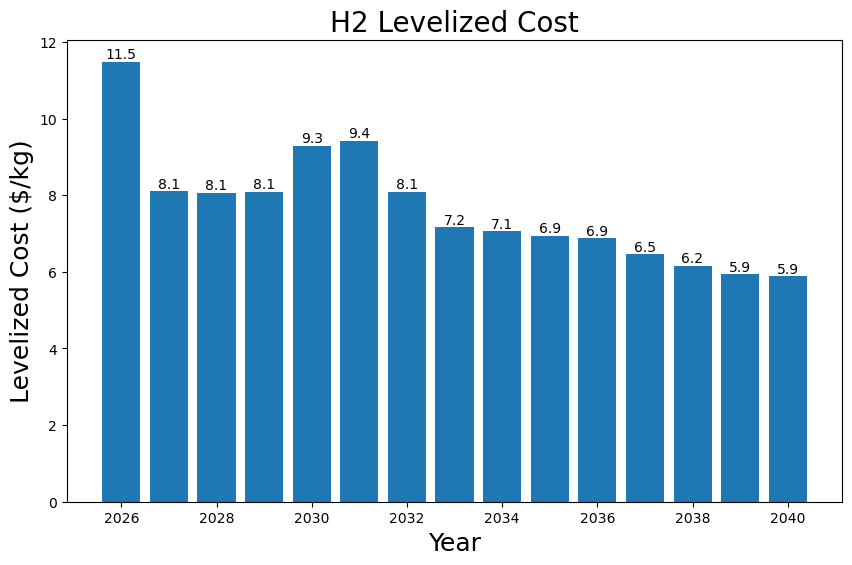

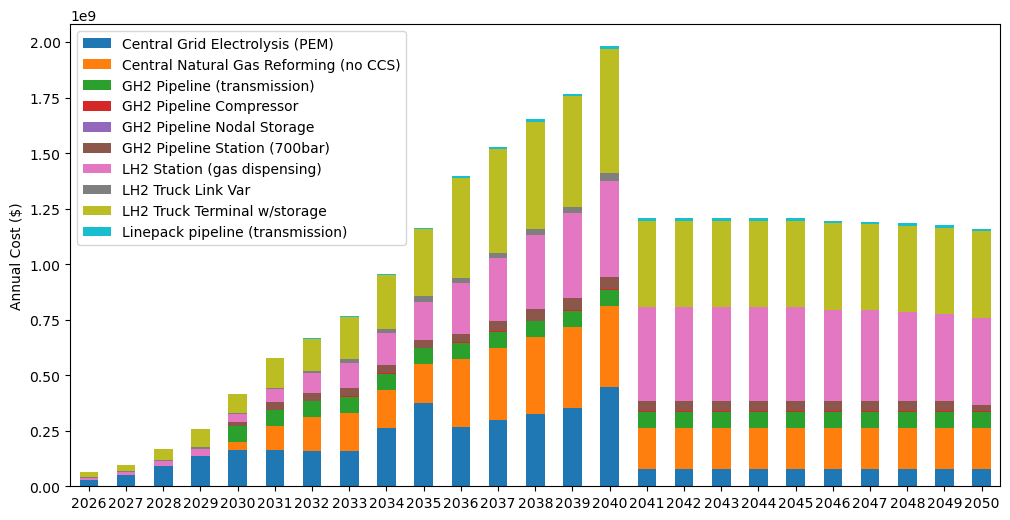

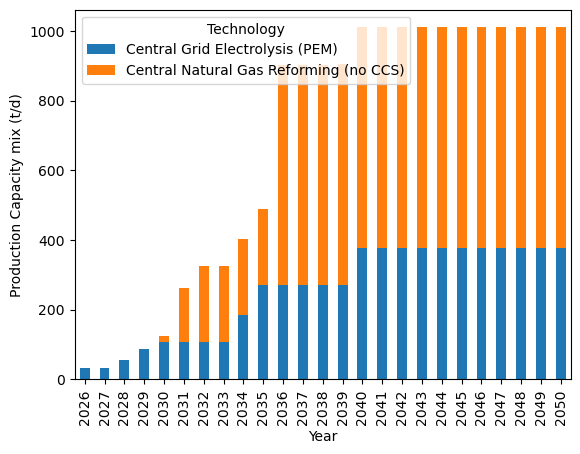

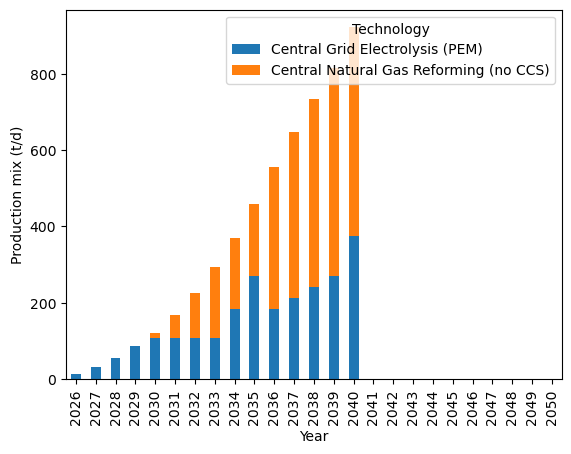

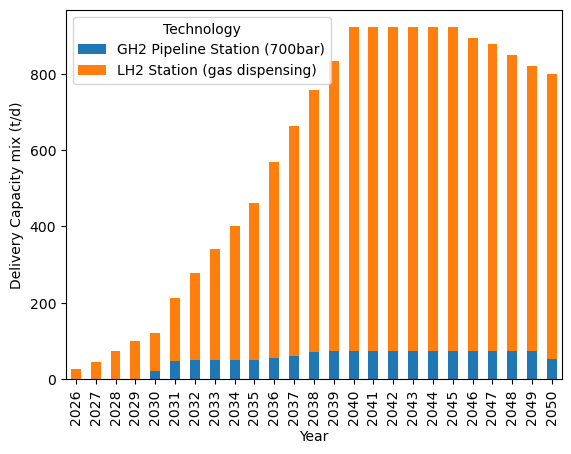

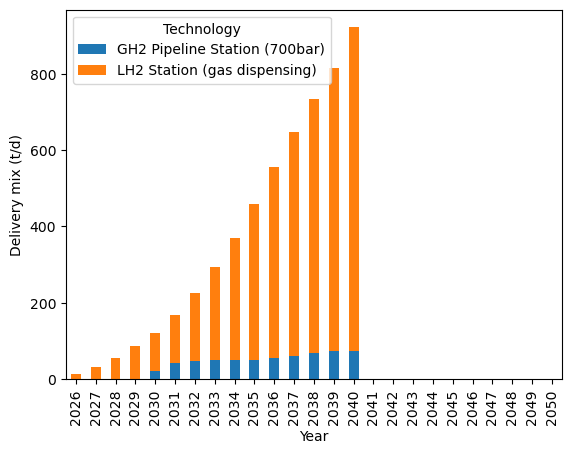

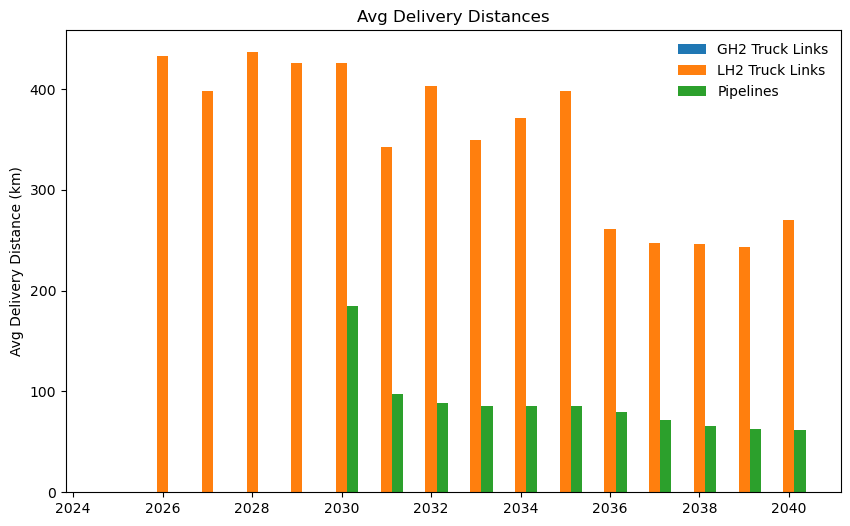

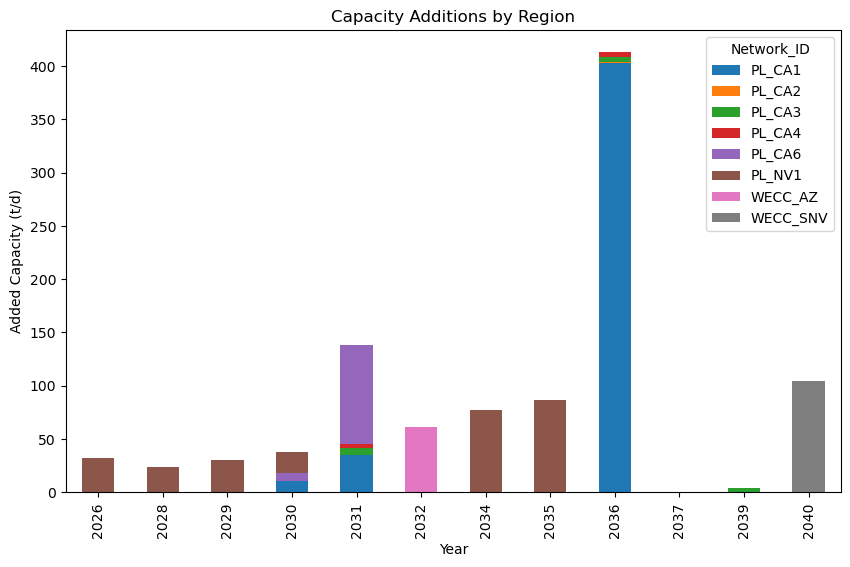

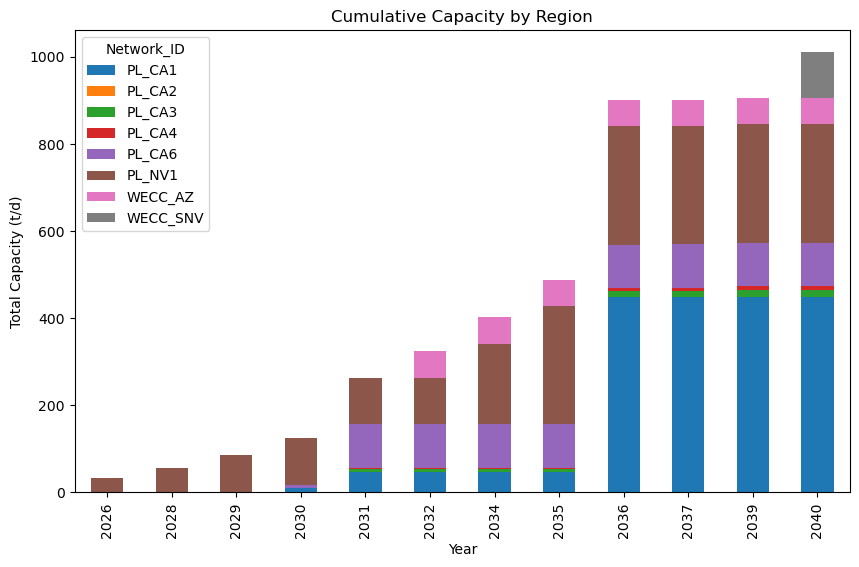

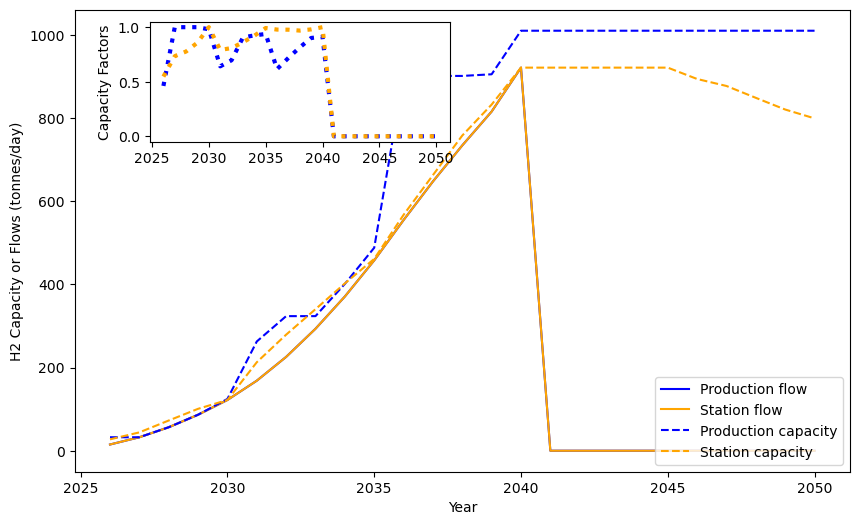

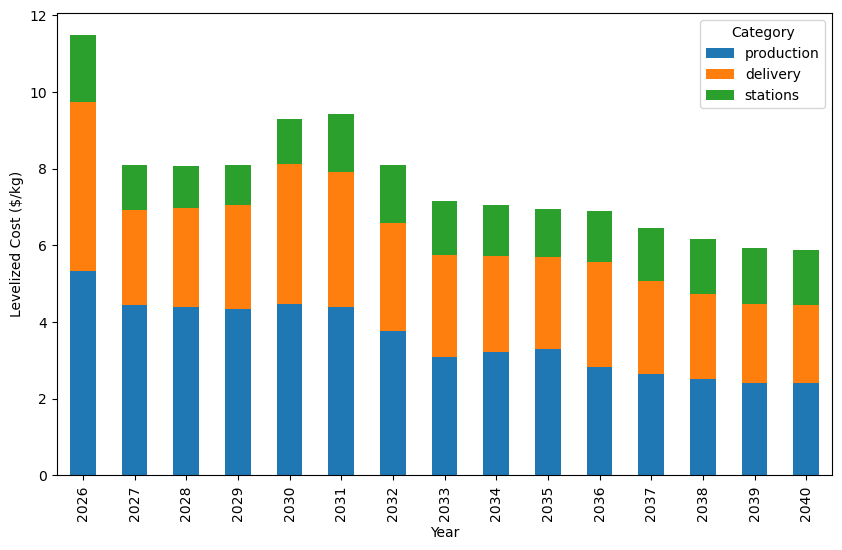

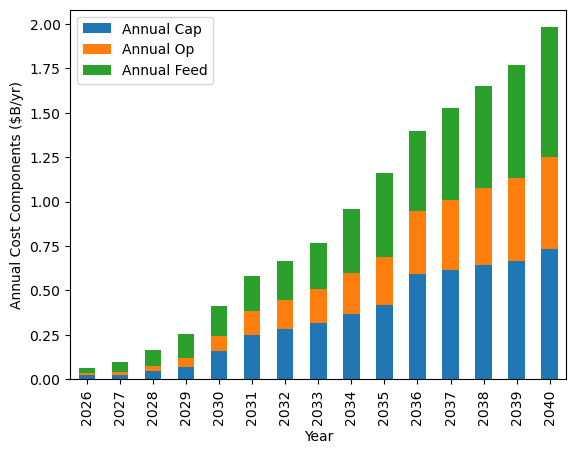

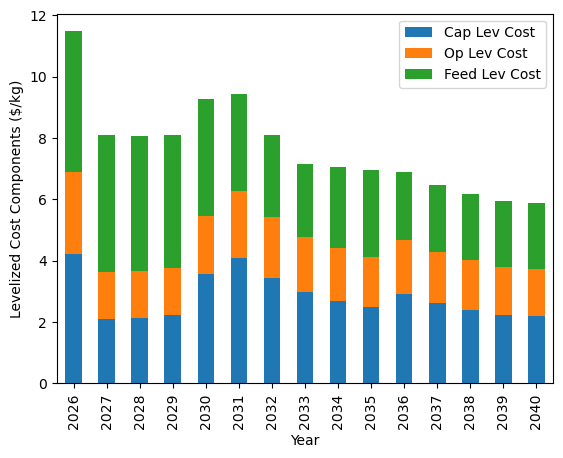

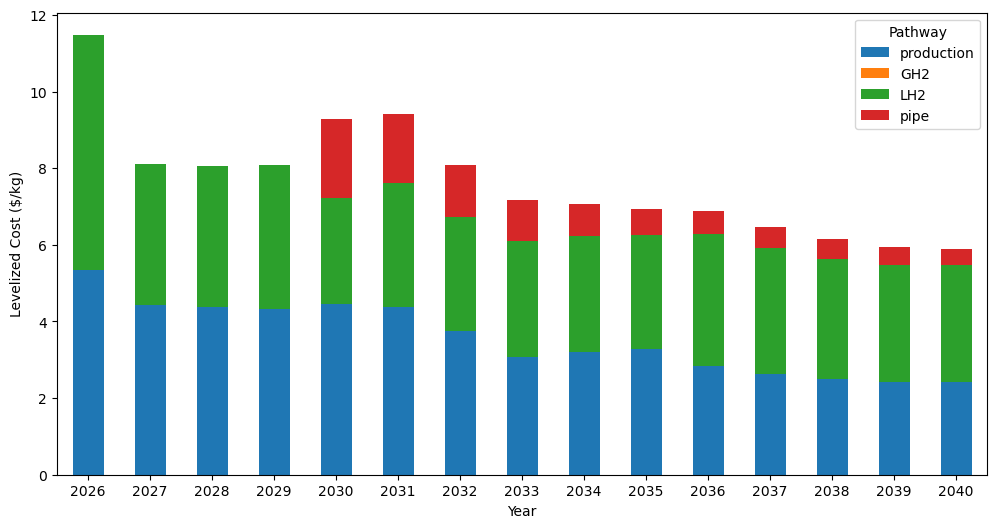

/opt/anaconda3/lib/python3.11/site-packages/matplotlib/transforms.py:2039: RuntimeWarning: invalid value encountered in scalar add
  self._mtx[1, 2] += ty
/opt/anaconda3/lib/python3.11/site-packages/matplotlib/transforms.py:372: RuntimeWarning: invalid value encountered in scalar subtract
  return (x0, y0, x1 - x0, y1 - y0)


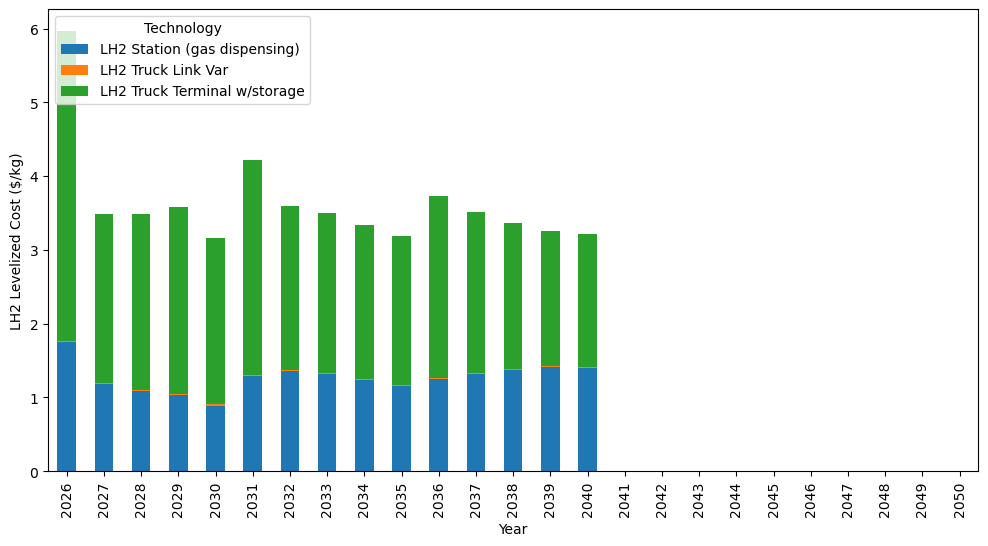

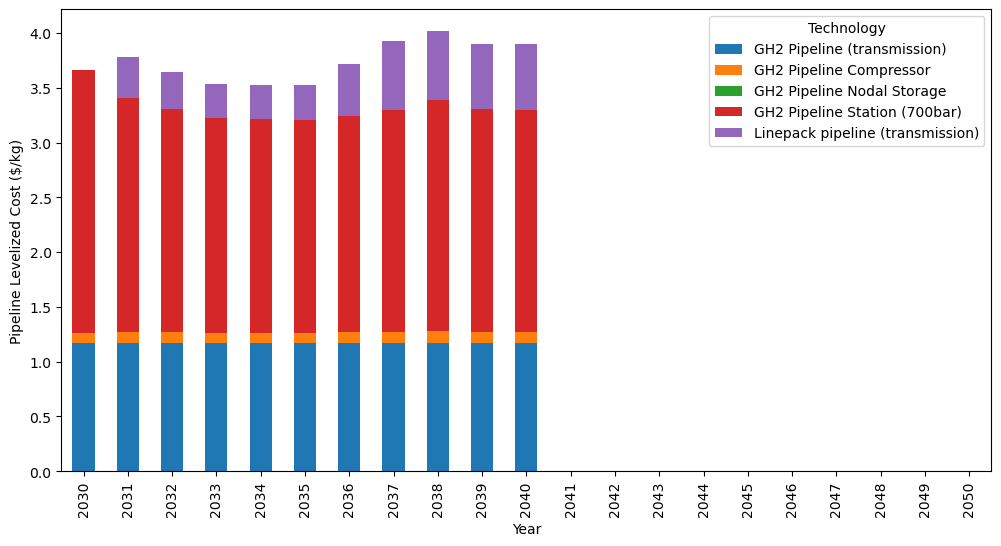

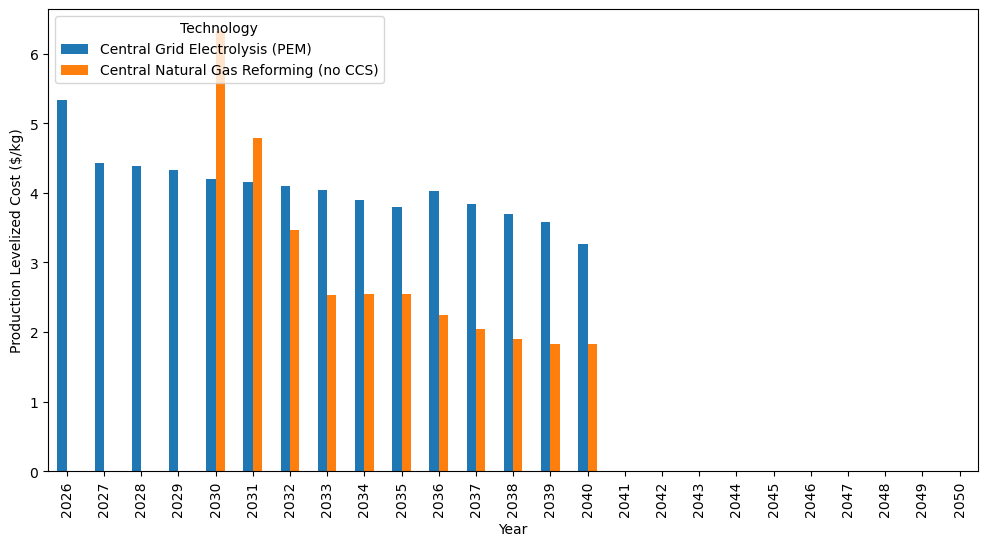

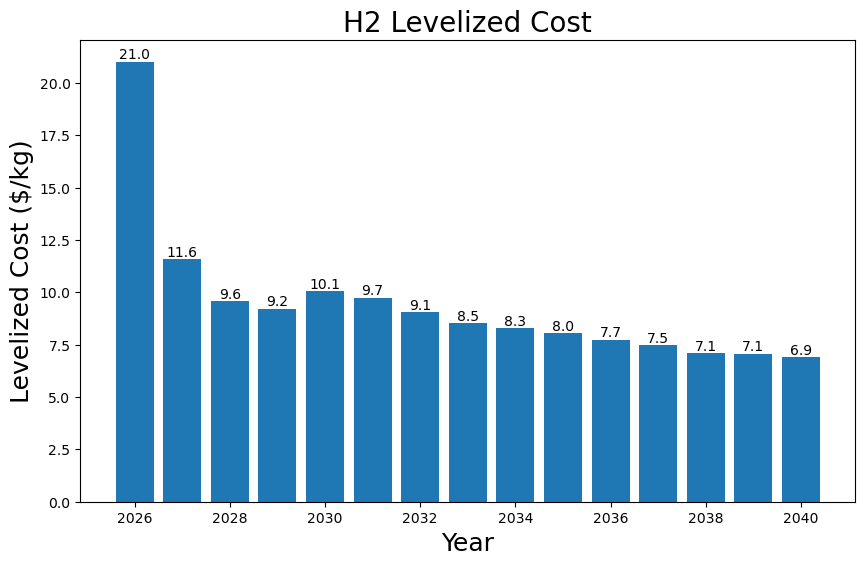

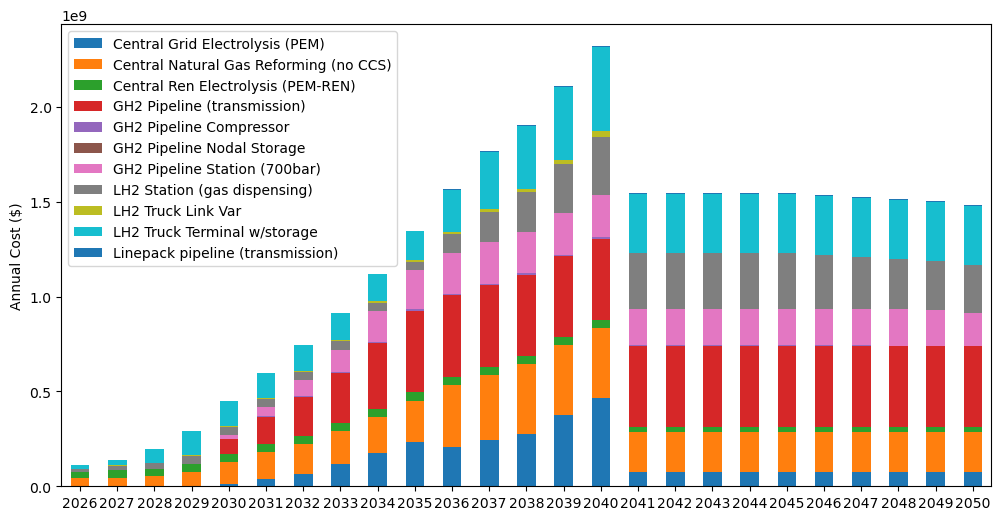

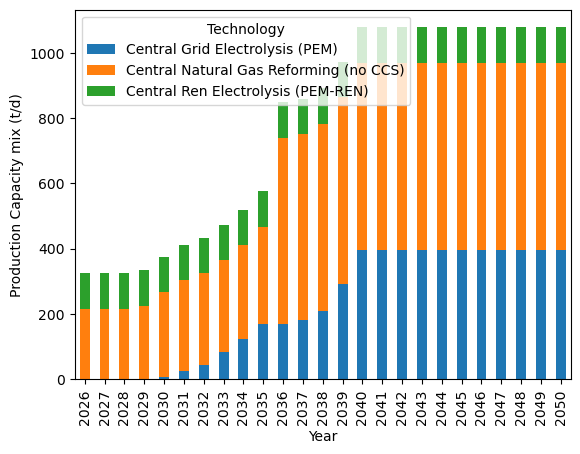

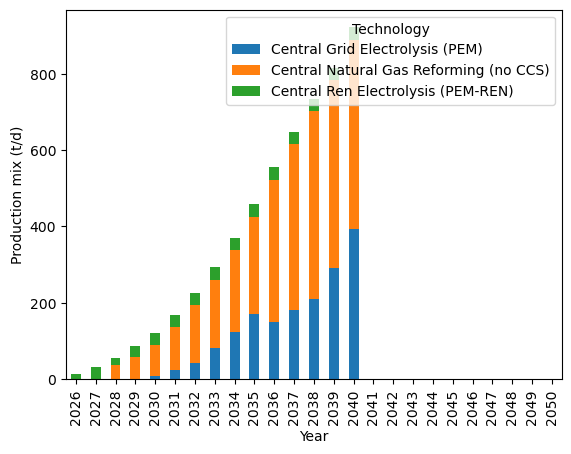

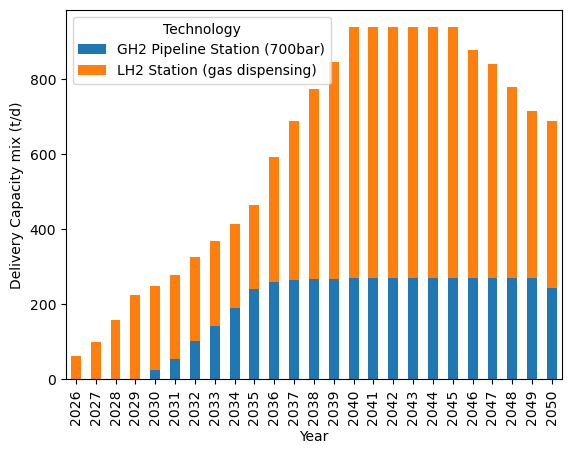

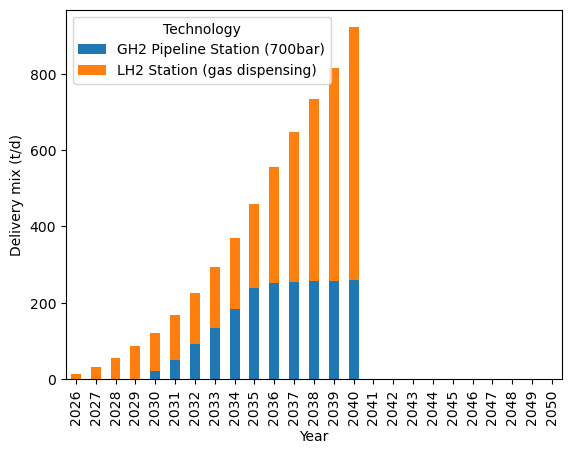

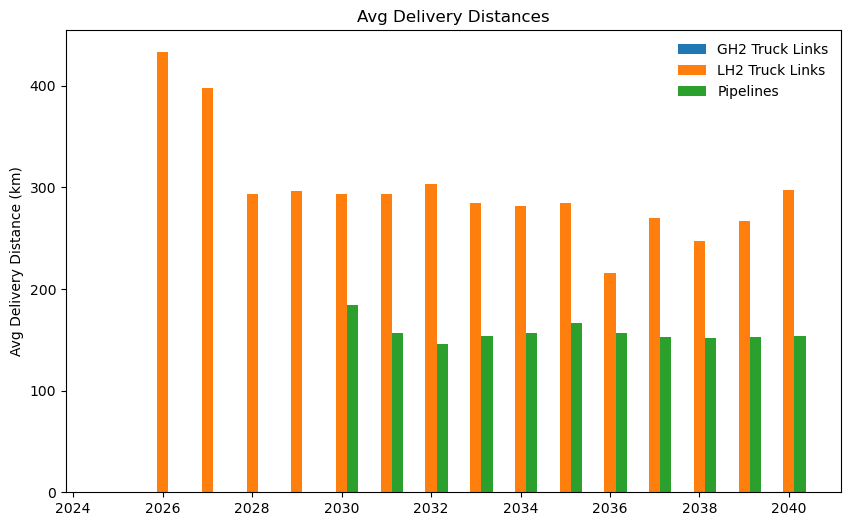

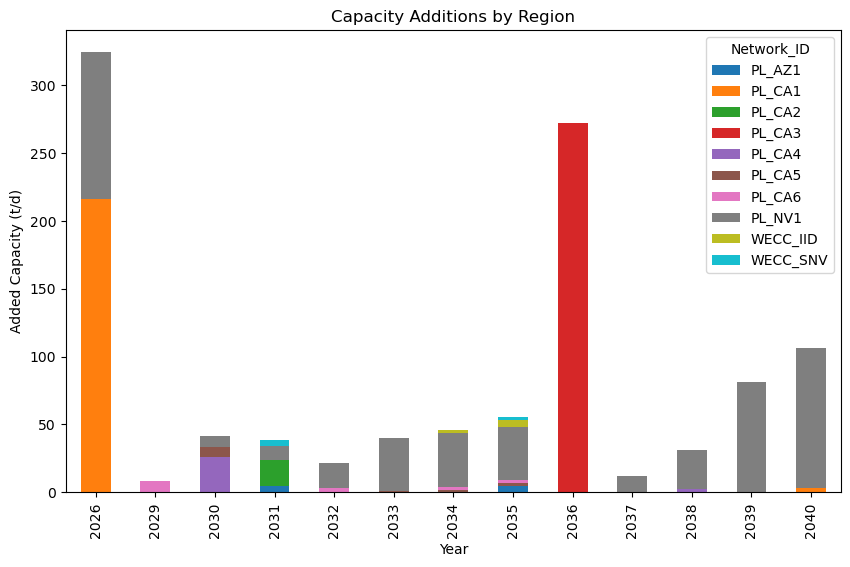

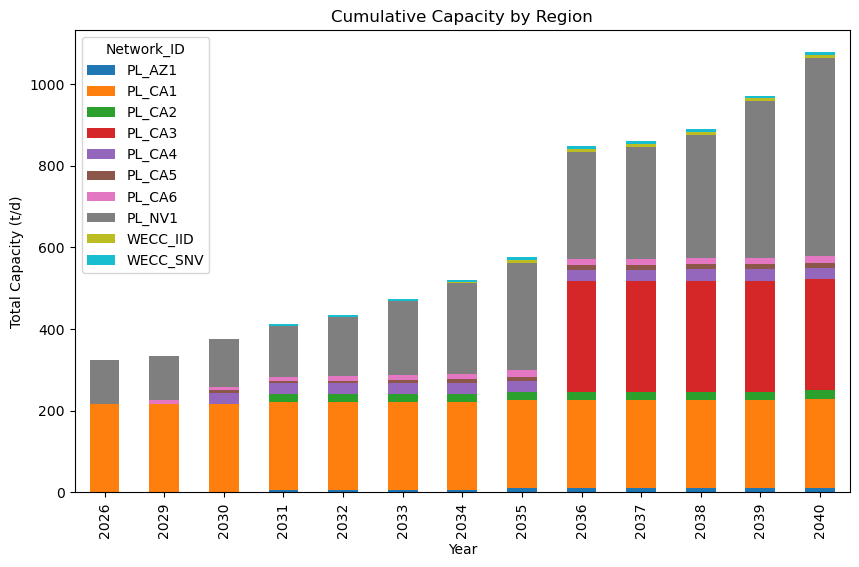

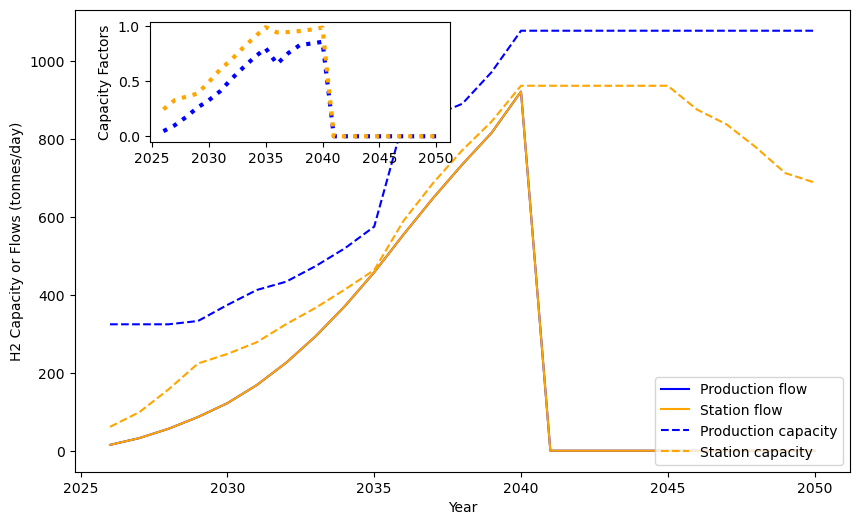

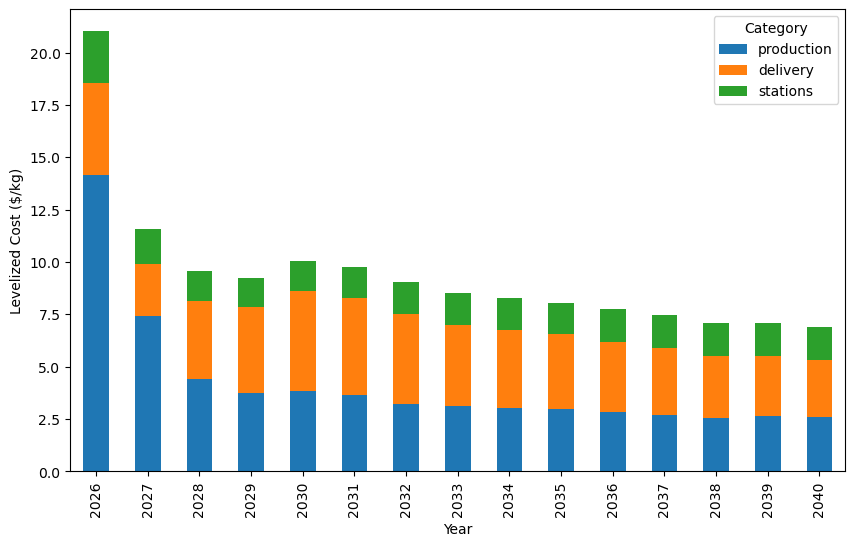

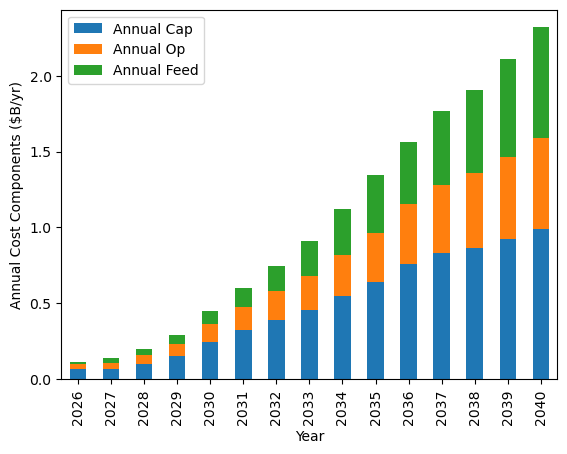

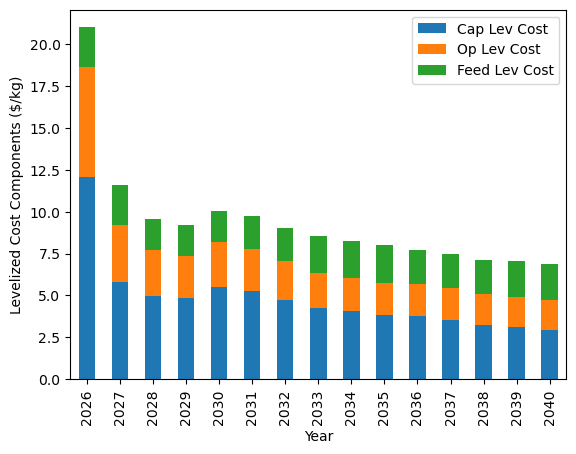

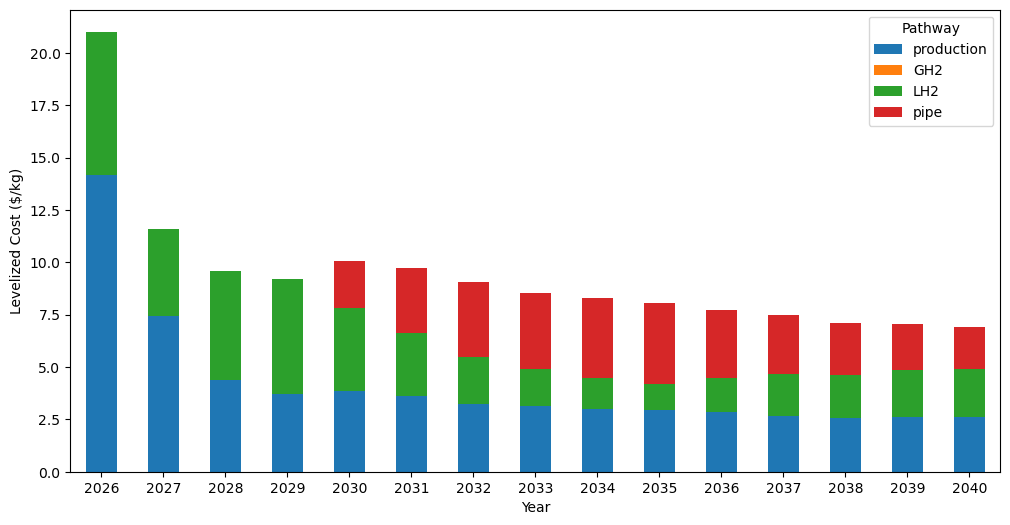

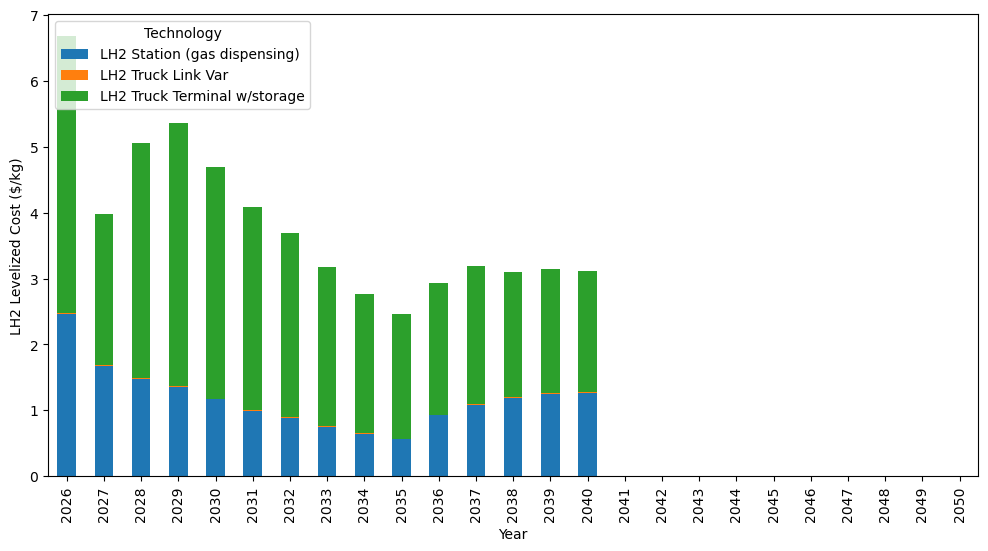

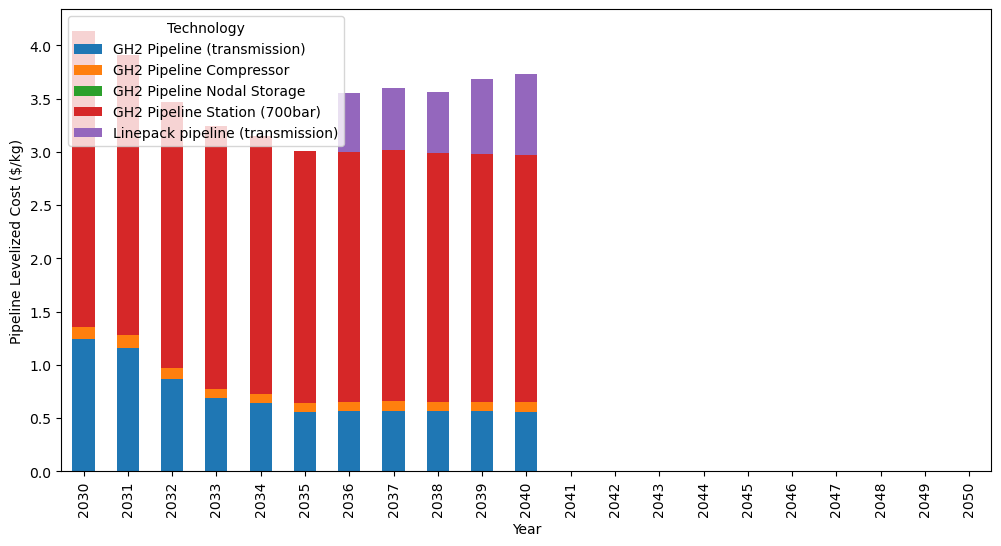

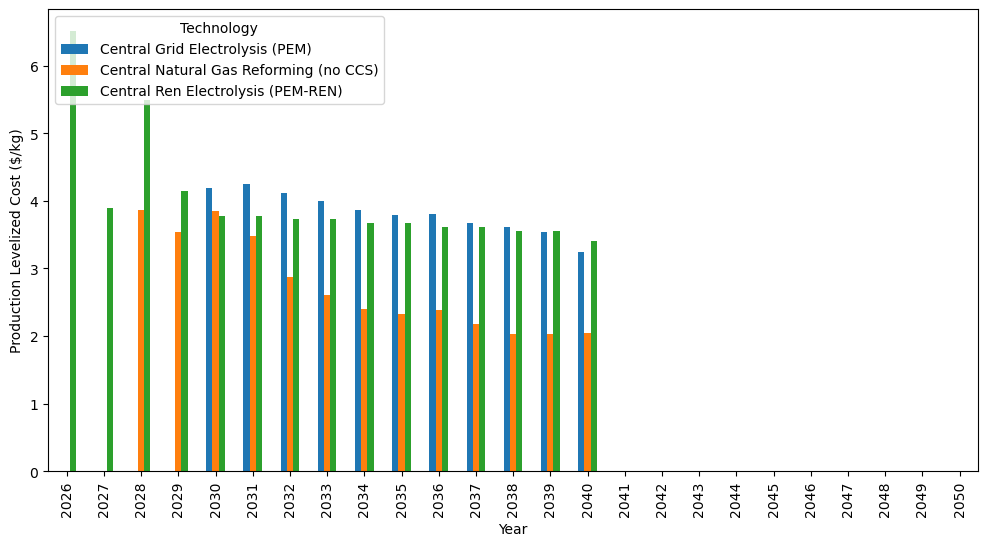

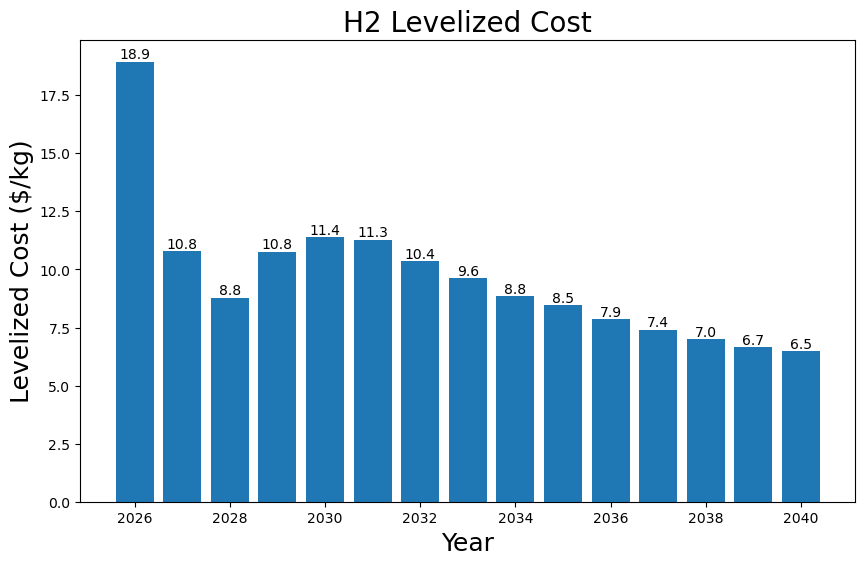

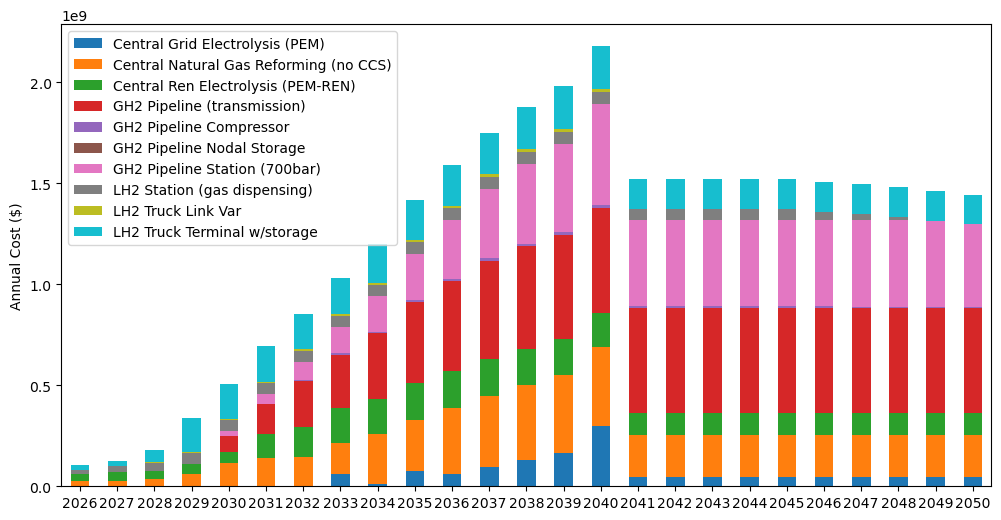

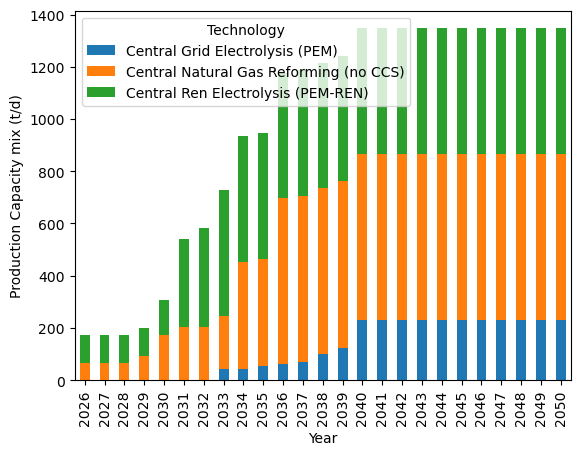

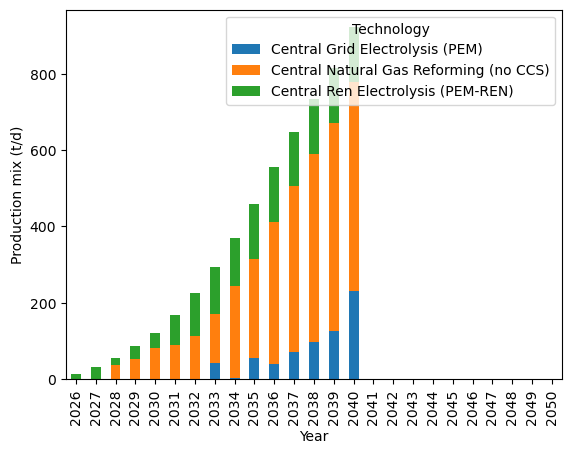

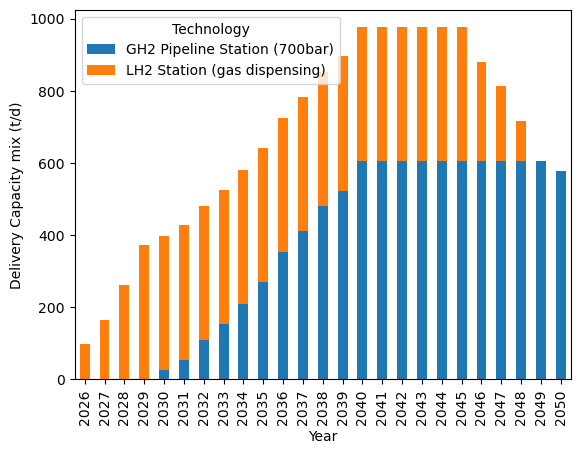

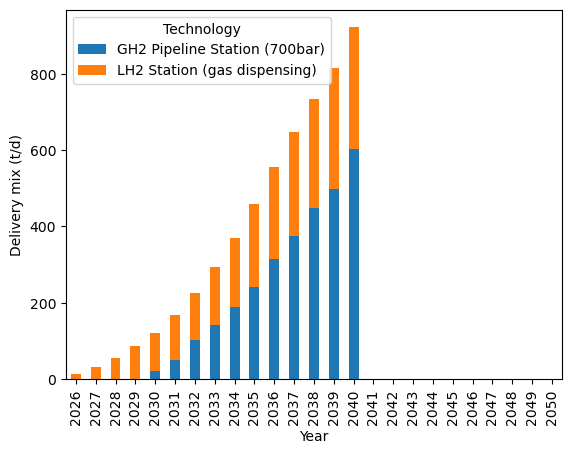

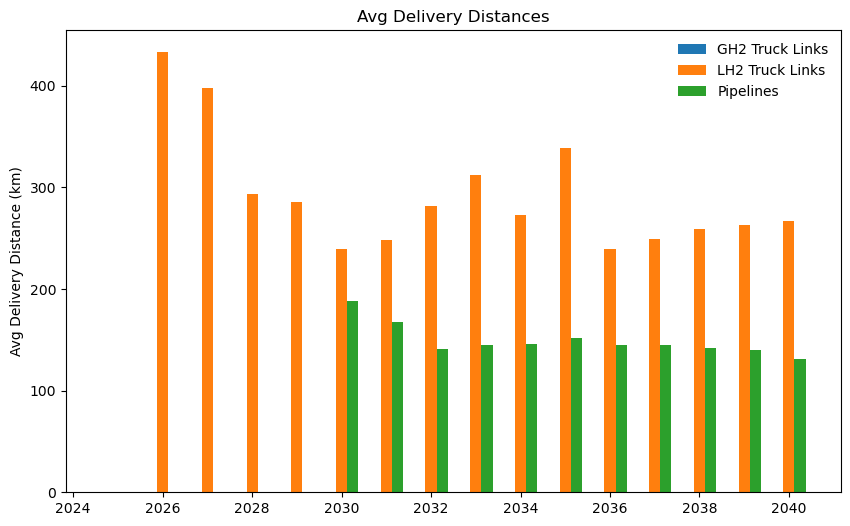

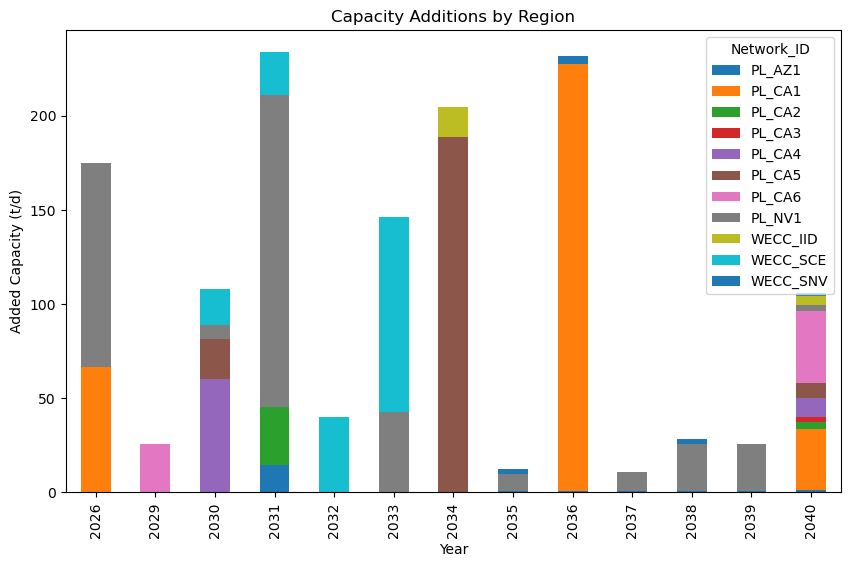

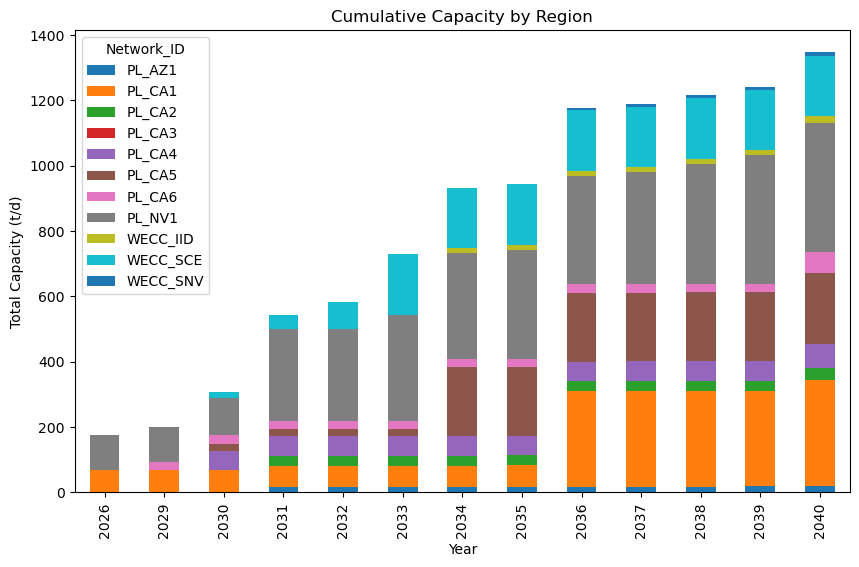

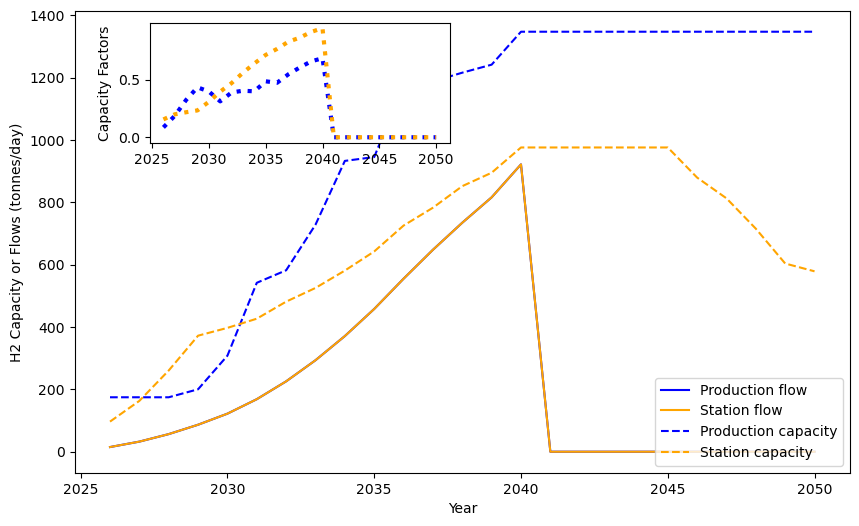

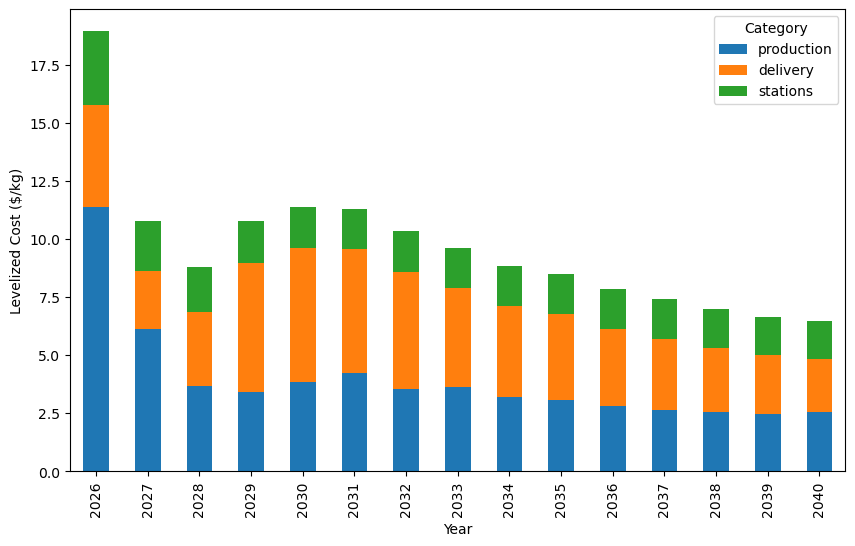

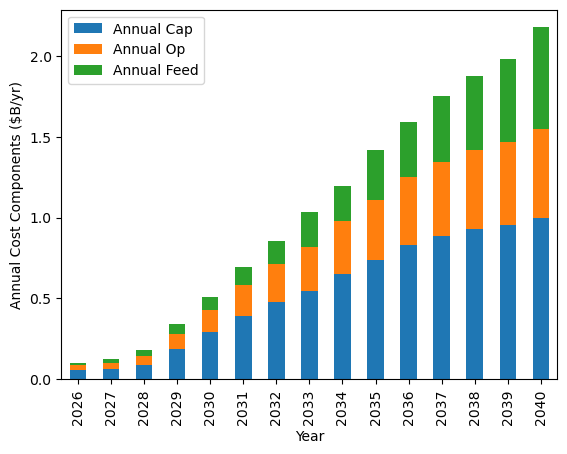

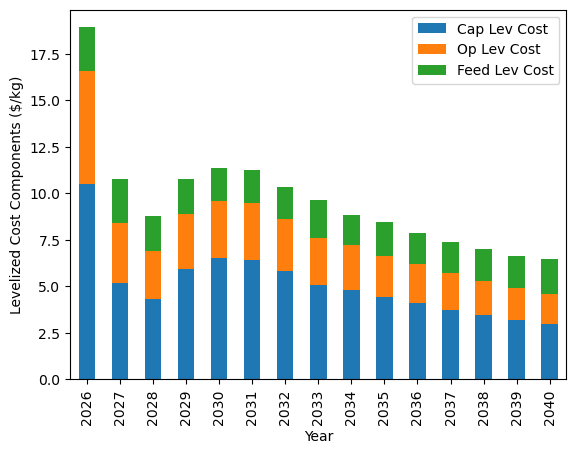

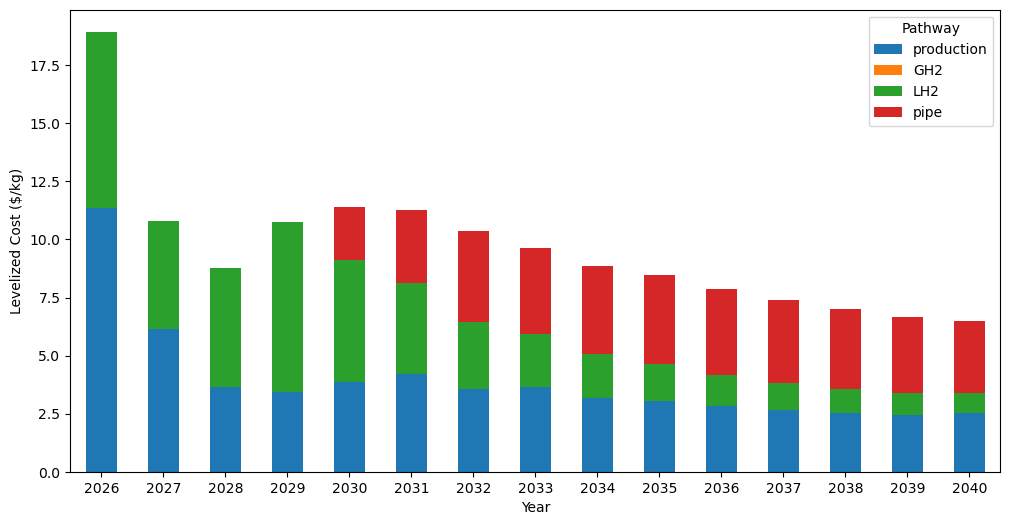

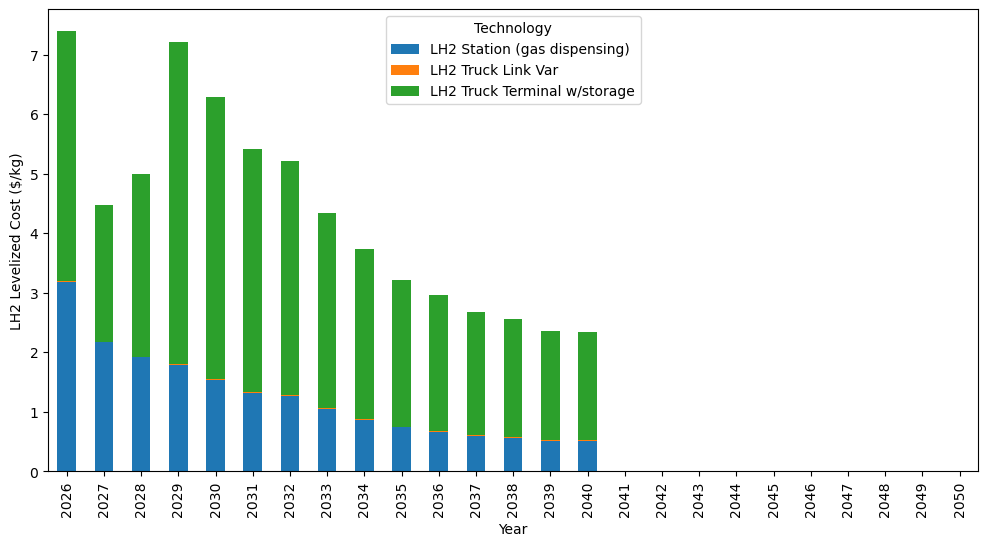

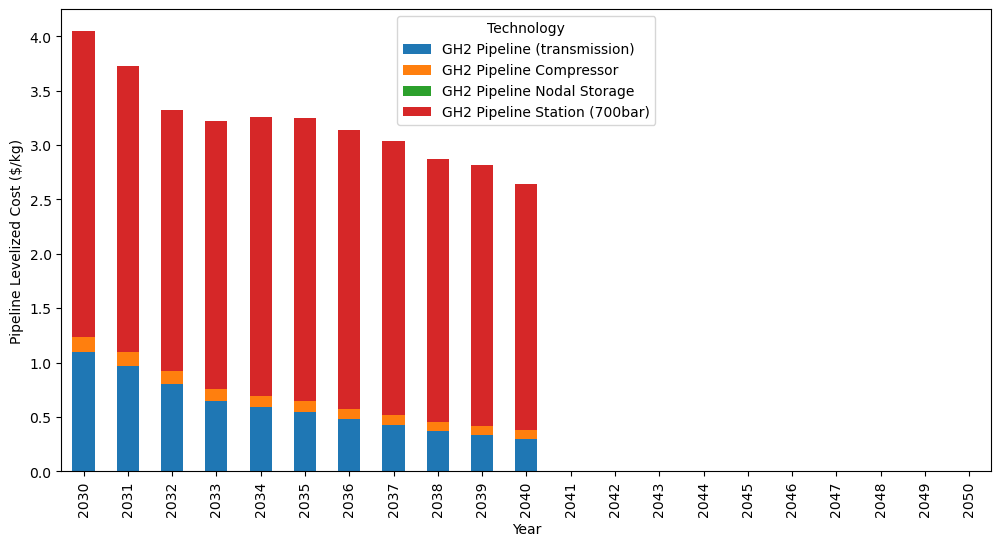

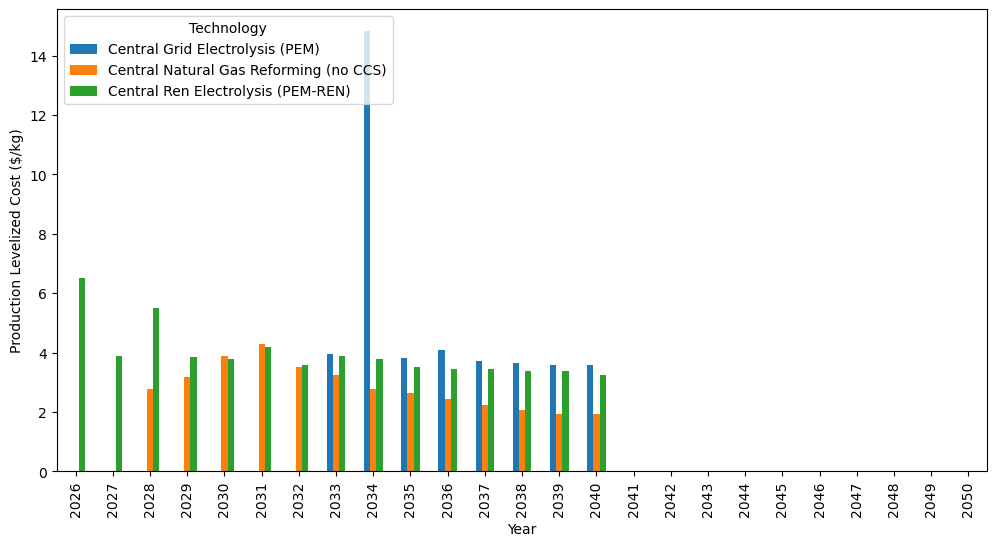

In [22]:
###########
# CELL #3 # This is the code to process the output folders in cell #1
###########

######
# this parameter determines whether you turn each line in the construction file 
# which represents a single technology built in a given year into
# a series of technologies with a line for every year of it's lifetime
# this is done because when merged with the flow file, sometimes the flow is variable
# and isn't used each year.  in this case, the capital costs aren't tallied correctly
# b/c they are only tallied in years with flow instead of every year in it's lifetime
expand_construction_df=True
#Hide figures?
hidefigs=False

overallstart = time.perf_counter()

plantlist=["Central Grid Electrolysis (PEM)","Central Ren Electrolysis (PEM-REN)","Central Natural Gas Reforming w/CCS","Central Natural Gas Reforming (no CCS)"]
stationlist=['GH2 Truck Station (700bar)','LH2 Station (gas dispensing)','GH2 Pipeline Station (700bar)']
delivery_components=['GH2 Truck','GH2 Truck Link Var','GH2 Pipeline Truck Terminal','LH2 Truck','LH2 Truck Link Var','LH2 Truck Terminal w/storage','GH2 Pipeline Compressor','GH2 Pipeline (transmission)','Linepack pipeline (transmission)','GH2 Pipeline Nodal Storage','GH2 Pipeline Salt Cavern Storage']
gastruck_components=['GH2 Truck Station (700bar)','GH2 Truck','GH2 Truck Link Var','GH2 Pipeline Truck Terminal']
liqtruck_components=['LH2 Station (gas dispensing)','LH2 Truck','LH2 Truck Link Var','LH2 Truck Terminal w/storage']
pipeline_components=['GH2 Pipeline Station (700bar)','GH2 Pipeline Compressor','GH2 Pipeline (transmission)','Linepack pipeline (transmission)','GH2 Pipeline Nodal Storage','GH2 Pipeline Salt Cavern Storage']
central_electrolysis_components=['Central Grid Electrolysis (PEM)',"Central Ren Electrolysis (PEM-REN)"]
central_SMR_components=['Central Natural Gas Reforming w/CCS',"Central Natural Gas Reforming (no CCS)"]
all_components=plantlist+gastruck_components+liqtruck_components+pipeline_components

initDeliveryNetworks()

# for i in range(0,len(files)):
for i in range(0,len(files)):
    starttimer = time.perf_counter()
    # starttimer = time.perf_counter()
    folder=files[i]['folder']
    results = files[i]['resultsfolder']
    print(folder)
    outputsfolder=results#+'outputs/'
    inputsfolder=folder+'inputs/'
    
    #grabs feedstock prices and inputs from the input files (using scenario.YAML)
    feedstockfolders=get_key_files_from_YAML()
    
    #GET MATERIAL/ENERGY INPUT FILES INTO DF
    delinputs_df=pd.read_csv(folder+feedstockfolders[0], sep='\t')
    prodinputs_df=pd.read_csv(folder+feedstockfolders[1], sep='\t')
    #GET LOCATION OF EVERY NETWORK ID (TAZ, LINK) # needs to be updated if/when links have multiple regions
    zones_df=pd.read_csv(folder+feedstockfolders[3], sep='\t')
    nodes_df=pd.read_csv(folder+feedstockfolders[4], sep='\t')
    nodes_df=nodes_df.rename(columns={'Network ID':'Network_ID','X':'lon','Y':'lat'})[['Network_ID','lat','lon']]
    links_df=pd.read_csv(folder+feedstockfolders[6],sep='\t')
    links_df[['From_lon','From_lat','To_lon','To_lat']]=links_df.apply(parse_geometry_col,axis=1,result_type='expand')
    links_df['Length [km]']=links_df['Length [km]'].astype(int)
    network_dict=zones_df.set_index('Network ID').to_dict()['Zone']
    TAZ_demand_df=pd.read_csv(folder+feedstockfolders[5],sep='\t')
    annual_station_df=TAZ_demand_df.groupby('Year').sum()[['Fueling-Station Demand [kg]']]
    
    #join the list of unique input materials
    listofinputs=set(list(delinputs_df['Material'].unique())).union(set(list(prodinputs_df['Material'].unique())))
    print(listofinputs)
    # list of input materials
    listofinputs.remove('Salt Cavern Available [kg]')
    all_inputs_df=pd.concat([prodinputs_df,delinputs_df])
    all_inputs_df[all_inputs_df['Technology'].isin(all_components)]
    all_inputs_df=all_inputs_df[all_inputs_df['Technology'].isin(all_components)]
    all_inputs_df=all_inputs_df[all_inputs_df['Material'].isin(listofinputs)]
    
    #GET PRICE FILE INTO DF
    prices_df=pd.read_csv(folder+feedstockfolders[2], sep='\t')
    ## Make dataframe into dict (faster)
    mats=list(prices_df['Material'].unique())
    zones=list(prices_df['Zone'].unique())
    prices_dict={}
    for mi in range(0,len(mats)):
        prices_dict[mats[mi]]={}
        for mj in range(0,len(zones)):
            prices_dict[mats[mi]][zones[mj]]={}
    # display(prices_dict)
    # for ri in range(0,len(prices_df)):
    for index, row in prices_df.iterrows():
        # row=prices_df.iloc[[ri]]
        prices_dict[row['Material']][row['Zone']][row['Year']]=row['Price [$/unit]']
        # prices_dict[row['Material'].iloc[0]][row['Zone'].iloc[0]][row['Year'].iloc[0]]=row['Price [$/unit]'].iloc[0]
        #prices_dict[material][zone][year]
        
    # READ IN CONSTRUCTION AND FLOW FILES 
    prefix=files[i]['code']+"_"
    seraconstruction=pd.read_csv(files[i]['folder']+'outputs/'+files[i]['const'], sep='\t')    
    seraflow=pd.read_csv(files[i]['folder']+'outputs/'+files[i]['flow'], sep='\t')
    
    seraflow = seraflow[(seraflow['Year'] >= yrs[0]) & (seraflow['Year'] <= yrs[1])]
    #seraconstruction=pd.read_csv(outputsfolder+files[i]['const'], sep='\t')    
    #seraflow=pd.read_csv(outputsfolder+files[i]['flow'], sep='\t')
    
    #add Levelized Cost Calculations
    seraconstruction['DailyCap']=seraconstruction['Nameplate_Capacity']/365000
    seraconstruction['EndYear']=seraconstruction['Year']+seraconstruction['Lifetime']
    seraconstruction['CRF']=CRF(.1,seraconstruction['Lifetime'])
    seraconstruction['Annual Cap']=seraconstruction['CRF']*seraconstruction['Capital_Cost']
    seraconstruction['Capital & Fixed Annual Cost']=seraconstruction['Annual Cap']+seraconstruction['Fixed_Operating_Cost']
    
    ######################################################################################################
    # This section is added to fix the issue with flow years not occuring in every year of 
    # a technology's lifetime
    # merging the construction and flow files (either with multiple lines per constructed 
    # technology (one for each year of lifetime) or just one
    ######################################################################################################
    if expand_construction_df==False:
        #this is what the section of code used to look like - merge construction and flow files
        seraconstruction_key=seraconstruction[['Infrastucture_ID','Network_ID','Nameplate_Capacity','DailyCap','Length','Variable_Operating_Cost','Storage_Capacity','EndYear','CRF','Annual Cap','Fixed_Operating_Cost','Capital & Fixed Annual Cost']]
        seraflow_full=seraflow.merge(seraconstruction_key, on="Infrastucture_ID", how='left')
    elif expand_construction_df==True:
        #this is waht this section of code is being replaced with
        # get a list of all technologies built
        # list_of_InfraIDs=list(seraconstruction['Infrastucture_ID'])
        # run down the list of technologies and expand so there is 1 row for each year of it's lifetime (to 2050)
        
        expanded_construction_data=[seraconstruction]
        print("starting expansion", end=" ")
        # for id in list_of_InfraIDs: # old   #SPEEDED UP BY USING ITERROWS
        for index, row in seraconstruction.iterrows():
            #grab the one row
            # tech_row=seraconstruction[seraconstruction['Infrastucture_ID']==id] # old 
            tech_row=row.copy()
            # display(tech_row)
            # get the years to populate for lifetime
            tech_yr=tech_row['Year']
            tech_life=tech_row['Lifetime']
            if tech_life<100:
                tech_range=range(int(tech_yr+1),min(int(tech_yr+tech_life),2051))
                tech_len=len(tech_range)
                # repeat this row for each year of lifetime
                # tech_df=tech_row.loc[tech_row.index.repeat(tech_len)]
                # print(tech_row)
                tech_rowdf=pd.DataFrame(tech_row).transpose()
                tech_df=tech_rowdf.loc[tech_rowdf.index.repeat(tech_len)]
                #replace years with range of years (not including initial construciton year)
                tech_df['Year']=list(tech_range)
                #add this to the list of
                expanded_construction_data.append(tech_df.copy())
                # print(len(expanded_construction_data),len(tech_df))
        print(" - ended", end=" ")
        endtimer = time.perf_counter()
        print(round(endtimer-starttimer), "seconds", end=" ")
        
        #once done all of the individual row expansion, concatenate everything
        seraconstruction_exp=pd.concat(expanded_construction_data)
        seraconstructionlength=len(seraconstruction_exp)
        
        #subset columns
        seraflow_key=seraflow[['Variable','Infrastucture_ID','Year','Production_kg','Flow_kg','Loss_kg','Cost','Salvage_Value']]
        seraconstruction_key=seraconstruction_exp[['Infrastucture_ID','Network_ID','Technology','Year','Lifetime','Nameplate_Capacity','Maximum_Utilization','DailyCap','Length','Variable_Operating_Cost','Storage_Capacity','EndYear','CRF','Annual Cap','Fixed_Operating_Cost','Capital & Fixed Annual Cost']]
        seraflow_full=seraflow_key.merge(seraconstruction_key,on=['Infrastucture_ID','Year'],how='right')
        # fill in blank data
        seraflow_full=seraflow_full.fillna(0)
        seraflow_full['Variable']=seraflow_full['Variable'].replace(0,'')
        seraflow_full['Year']=seraflow_full['Year'].astype(int)
        
    # Calculate all costs
    seraflow_full = seraflow_full.rename(columns={'Variable_Operating_Cost': 'Var_Op_Cost_per_kg'})
    seraflow_full['H2_kg']=seraflow_full['Flow_kg']+seraflow_full['Production_kg']
    seraflow_full['TotalVarCost']=seraflow_full['Var_Op_Cost_per_kg']*seraflow_full['H2_kg']
    #drop rows with no costs and no flows (mostly unused truck capacity, because trucks have no capital costs)
    noflow_nocost=seraflow_full[(seraflow_full['Capital & Fixed Annual Cost']==0) & (seraflow_full['H2_kg']==0)].index
    seraflow_full=seraflow_full.drop(noflow_nocost)
    seraflow_full['Category']=seraflow_full.apply(get_category1,axis=1)
    seraflow_full['Pathway']=seraflow_full.apply(get_Pathway,axis=1)

    # CALCULATE MATERIAL/FEEDSTOCK ANNUAL COSTS HERE
    # Make Multiple Columns: Material X, Material X Price, Material Y, Material Y Price,. . . 
    # ADD MATERIAL AND PRICE CELLS TO DF
    # from testing cell #4

    print("starting feedstock part ", end=" ")
    for item in listofinputs:
        seraflow_full[item]=0
        item_price=item.replace(" [","-price [$/")
        seraflow_full[item_price]=0
    
    techs_w_inputs_list=list(all_inputs_df['Technology'].unique())
    techs_w_inputs_dict={}
    ind_i=0
    twopct=round(len(seraflow_full)*.02)
    tech_feedstock_input_dict={}
    ##STEP THROUGH EACH TECHNOLOGY TYPE 
    for tech in techs_w_inputs_list:
        tech_feedstock_input_dict[tech]={}
        tech_x_inputs_df=all_inputs_df.query('Technology==@tech')
        tech_x_inputs_list=list(tech_x_inputs_df['Material'].unique())
        techs_w_inputs_dict[tech]=tech_x_inputs_list
    
        #from testing cell #5
        # tech_x_serafull=seraflow_full[seraflow_full['Technology']==tech & seraflow_full['H2_kg']>0]
        #Only calculate feedstock costs for technologies with non-zero H2 flows (not idled technologies)
        tech_x_serafull=seraflow_full.query('Technology==@tech and H2_kg>0')
        tech_feedstock_inputs=techs_w_inputs_dict[tech]
        
        #### MAKE A DICT THAT INCLUDES:
        ####     LIST OF ALL YEARS FOR EACH INPUT TECHNOLOGY / FEEDSTOCK COMBO
        ####     TABLES OF FEEDSTOCK INPUT TABLES FOR EACH INPUT TECHNOLOGY / FEESTOCK / YR COMBO (includes different sizes)
        # faster to pregenerate all these tables and lists once instead of for each row 
        for feedstock in tech_feedstock_inputs:
            tech_feedstock_input_dict[tech][feedstock]={}
            tech_feedstock_input_dict[tech][feedstock]['Years']=list(all_inputs_df[(all_inputs_df['Technology']==tech) & (all_inputs_df['Material']==feedstock)].Year.unique())
            tech_feedstock_input_dict[tech][feedstock]['Tables']={}
            for yr in tech_feedstock_input_dict[tech][feedstock]['Years']:
                tech_feedstock_input_dict[tech][feedstock]['Tables'][yr]=all_inputs_df[(all_inputs_df['Technology']==tech) & (all_inputs_df['Material']==feedstock) & (all_inputs_df['Year']==yr)]
        # display(tech_feedstock_input_dict)
        ## STEP THROUGH EACH INSTANCE OF THE TECHNOLOGY - ONE ROW
        # for i in range(0,len(tech_x_serafull)):
        for index, row in tech_x_serafull.iterrows():
            # ind_i+=1
            # if ind_i%twopct==0:
            #     print(ind_i/twopct*.02, end=" ")
            # rowtech=tech_x_serafull.iloc[[i]]
            rowtech = row
            
            # if (rowtech['H2_kg'].iloc[0])>0:
            # techind=rowtech.index[0]
            techind=index
            techyr=rowtech['Year']
            techcap=rowtech['Nameplate_Capacity']
            techreg=rowtech['Network_ID']
            techzone=network_dict[techreg]
            seraflow_full.loc[techind,'Zone']=techzone
            ## WITHIN EACH ROW, STEP THROUGH DIFFERENT INPUT FEEDSTOCKS
            for feedstock in tech_feedstock_inputs:
                ##### GET FEEDSTOCK INTENSITY
                # tech_x_input_yrs=list(tech_x_inputs_df[tech_x_inputs_df['Material']==feedstock]['Year'].unique())
                
                
                tech_x_input_yrs=tech_feedstock_input_dict[tech][feedstock]['Years']
                closest_year=get_nearest_year_before(techyr,tech_x_input_yrs)
                # feedstock_lookup_table=tech_x_inputs_df.query('Year==@closest_year & Material==@feedstock')
                # feedstock_lookup_table=tech_x_inputs_df[(tech_x_inputs_df['Year']==closest) & (tech_x_inputs_df['Material']==feedstock)]
                feedstock_lookup_table=tech_feedstock_input_dict[tech][feedstock]['Tables'][closest_year]
                # display(feedstock_lookup_table)
                if feedstock=='Diesel [gal]':
                    feedstock_cons=table_scale_interpolation_v2(techcap,'Nameplate Capacity [kg/yr]','Consumption [unit/km/kg]',feedstock_lookup_table,0)
                else:
                    feedstock_cons=table_scale_interpolation_v2(techcap,'Nameplate Capacity [kg/yr]','Consumption [unit/kg]',feedstock_lookup_table,0)
                seraflow_full.loc[techind,feedstock]=feedstock_cons
                ##### GET PRICE OF FEEDSTOCK IN REGION
                # price_lookup_table_feedstock_y=prices_df[prices_df['Material']==feedstock]
                # #get feedstock price that is specific to region of technology and year
                # feedstockprice=price_lookup_table_feedstock_y.query("Zone==@techzone and Year==@techyr")['Price [$/unit]'].iloc[0]
                #USE DICT instead of DF
                feedstockprice=prices_dict[feedstock][techzone][techyr]
                feedstock_price_col_name=feedstock.replace(" [","-price [$/")
                seraflow_full.loc[techind,feedstock_price_col_name]=feedstockprice
    ##### ADD COSTS TO GET TOTAL ANNUAL COSTS
    seraflow_full['Feedstock Annual Cost']=(seraflow_full['H2_kg'])*(seraflow_full['Water Total [gal]']*seraflow_full['Water Total-price [$/gal]']+seraflow_full['Diesel [gal]']*seraflow_full['Diesel-price [$/gal]']+seraflow_full['Natural Gas (Industrial) [MMBtu]']*seraflow_full['Natural Gas (Industrial)-price [$/MMBtu]']+seraflow_full['Electricity (Industrial) [kWh]']*seraflow_full['Electricity (Industrial)-price [$/kWh]']+seraflow_full['Electricity (Renewable) [kWh]']*seraflow_full['Electricity (Renewable)-price [$/kWh]'])
    seraflow_full['O&M Cost (Fix+Var)']=seraflow_full['Fixed_Operating_Cost']+seraflow_full['TotalVarCost']
    seraflow_full['Total Annual Cost']=seraflow_full['Capital & Fixed Annual Cost']+seraflow_full['TotalVarCost']+seraflow_full['Feedstock Annual Cost']
    
    endtimer=time.perf_counter()
    print("final", round(endtimer-starttimer), "seconds", end=" ")
    seraflow_full.to_csv(outputsfolder+"seraflow_full.csv",index=False)
    endtimer=time.perf_counter()
    print("total", round(endtimer-overallstart), "sec", end=" ")
    
    ##### Make Graphs - put functions here ######
    graph_aggregate_lev_cost()
    graph_annual_costs()
    graph_production_delivery_mix()
    graph_delivery_distances()
    production_location()
    caps_and_flows()
    storageflows()
    category_levelized_cost()
    CapOpFeed_levelized_cost()
    pathway_levelized_cost()
    make_links_file_for_leaflet()
    #make_links_file_for_leaflet2()
    gastruck_summary=makeDeliveryModeLevCostFigDF(gastruck_components,True,"GH2 ")
    liqtrucks_summary=makeDeliveryModeLevCostFigDF(liqtruck_components,True,"LH2 ")
    pipelines_summary=makeDeliveryModeLevCostFigDF(pipeline_components,True,"Pipeline ")
    production_summary=makeDeliveryModeLevCostFigDF(plantlist,False,"Production ")
    #############################################
    





In [4]:
def make_links_file_for_leaflet():
    ### Making Maps
    ## Saving a CSV with all the delivery links so it can be mapped in leaflet
    tech__loc_and_year_df=seraflow_full.groupby(['Technology','Network_ID','Year']).sum()
    ### export this for use in leaflet by scenario
    ## export H2_kg
    tech__loc_and_year_df=tech__loc_and_year_df[['H2_kg']].reset_index()
    #add in nodes
    tech__loc_and_year_df=tech__loc_and_year_df.merge(nodes_df,on="Network_ID",how="left")

    ## add in links
    ## TODO: need to get net flows for links.csv file which is used to generate maps
    links_df2=links_df[['Network ID','From_lon','From_lat','To_lon','To_lat','Length [km]']].rename(columns={'Network ID':'Network_ID'})
    links_df2[['From_lon','From_lat','To_lon','To_lat']]=links_df2[['From_lon','From_lat','To_lon','To_lat']].astype(float)
    tech__loc_and_year_df=tech__loc_and_year_df.merge(links_df2,on="Network_ID",how="left")
    tech__loc_and_year_df[['From_lon','From_lat','To_lon','To_lat']]=tech__loc_and_year_df[['From_lon','From_lat','To_lon','To_lat']].round(decimals = 3)
    deliverylinks=['GH2 Pipeline (transmission)','Linepack pipeline (transmission)','LH2 Truck Link Var','GH2 Truck Link Var']
    delivery_link_df=tech__loc_and_year_df[tech__loc_and_year_df['Technology'].isin(deliverylinks)]
    delivery_link_df['Technology']=delivery_link_df['Technology'].replace({'LH2 Truck Link Var':'LH2','GH2 Truck Link Var':'GH2','GH2 Pipeline (transmission)':'pipeline','Linepack pipeline (transmission)':'linepack'})
    delivery_link_df['Technology'].value_counts()
    delivery_link_df['Length [km]']=delivery_link_df['Length [km]'].astype(int)
    delivery_link_df.to_csv(results+"links.csv",index=False)
    points=['LH2 Station (gas dispensing)','GH2 Pipeline Station (700bar)','GH2 Truck Station (700bar)',
           'Central Grid Electrolysis (PEM)','Central Ren Electrolysis (PEM-REN)','Central Natural Gas Reforming w/CCS']
    points_df=tech__loc_and_year_df[tech__loc_and_year_df['Technology'].isin(points)]
    points_df['Technology']=points_df['Technology'].replace({'LH2 Station (gas dispensing)':'LH2','GH2 Pipeline Station (700bar)':'pipeline','GH2 Truck Station (700bar)':'GH2',
           'Central Grid Electrolysis (PEM)':'PEM','Central Ren Electrolysis (PEM-REN)':'PEM-REN','Central Natural Gas Reforming w/CCS':'SMRwCCS'})
    # display(points_df.head())
    points_df['H2_kg']=points_df['H2_kg'].astype(int)
    points_df=points_df[['Technology','Network_ID','Year','H2_kg','lat','lon']]
    points_df.to_csv(results+"points.csv",index=False)

In [5]:
make_links_file_for_leaflet()

/var/folders/09/yrvvq_l572z7n8k__h_yrl5r0000gn/T/ipykernel_919/2196948808.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivery_link_df['Technology']=delivery_link_df['Technology'].replace({'LH2 Truck Link Var':'LH2','GH2 Truck Link Var':'GH2','GH2 Pipeline (transmission)':'pipeline','Linepack pipeline (transmission)':'linepack'})
/var/folders/09/yrvvq_l572z7n8k__h_yrl5r0000gn/T/ipykernel_919/2196948808.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivery_link_df['Length [km]']=delivery_lin

In [17]:
 tech__loc_and_year_df=seraflow_full.groupby(['Technology','Network_ID','Year']).sum()
tech__loc_and_year_df

Variable  \
Technology                       Network_ID Year                                             
Central Grid Electrolysis (PEM)  PL_NV1     2026                                Production   
                                            2027                                Production   
                                            2028                      ProductionProduction   
                                            2029            ProductionProductionProduction   
                                            2030  ProductionProductionProductionProduction   
...                                                                                    ...   
Linepack pipeline (transmission) link_0508  2046                                             
                                            2047                                             
                                            2048                                             
                                            2049                                             
                                            2050                                             

                                                                                   Infrastucture_ID  \
Technology                       Network_ID Year                                                      
Central Grid Electrolysis (PEM)  PL_NV1     2026   INFR_PL_NV1_Central_Grid_Electrolysis_(PEM)_2026   
                                            2027   INFR_PL_NV1_Central_Grid_Electrolysis_(PEM)_2026   
                                            2028  INFR_PL_NV1_Central_Grid_Electrolysis_(PEM)_20...   
                                            2029  INFR_PL_NV1_Central_Grid_Electrolysis_(PEM)_20...   
                                            2030  INFR_PL_NV1_Central_Grid_Electrolysis_(PEM)_20...   
...                                                                                             ...   
Linepack pipeline (transmission) link_0508  2046  INFR_PL_CA6_link_0508_Pipeline_linepack_2_2031...   
                                            2047  INFR_PL_CA6_link_0508_Pipeline_linepack_2_2031...   
                                            2048  INFR_PL_CA6_link_0508_Pipeline_linepack_2_2031...   
                                            2049  INFR_PL_CA6_link_0508_Pipeline_linepack_2_2031...   
                                            2050  INFR_PL_CA6_link_0508_Pipeline_linepack_2_2031...   

                                                  Production_kg  Flow_kg  \
Technology                       Network_ID Year                           
Central Grid Electrolysis (PEM)  PL_NV1     2026      5459084.0      0.0   
                                            2027     11832791.0      0.0   
                                            2028     20623885.0      0.0   
                                            2029     31609475.0      0.0   
                                            2030     39032274.0      0.0   
...                                                         ...      ...   
Linepack pipeline (transmission) link_0508  2046            0.0      0.0   
                                            2047            0.0      0.0   
                                            2048            0.0      0.0   
                                            2049            0.0      0.0   
                                            2050            0.0      0.0   

                                                  Loss_kg          Cost  \
Technology                       Network_ID Year                          
Central Grid Electrolysis (PEM)  PL_NV1     2026      0.0  2.114698e+07   
                                            2027      0.0  4.452857e+07   
                                            2028      0.0  7.645734e+07   
                                            2029      0.0  1.154290e+08   
                                            2030      0.0  1.382025e+08   
...  

In [18]:
 tech__loc_and_year_df=tech__loc_and_year_df[['H2_kg']].reset_index()
 tech__loc_and_year_df

,Technology,Network_ID,Year,H2_kg
0,Central Grid Electrolysis (PEM),PL_NV1,2026,5459084.0
1,Central Grid Electrolysis (PEM),PL_NV1,2027,11832791.0
2,Central Grid Electrolysis (PEM),PL_NV1,2028,20623885.0
3,Central Grid Electrolysis (PEM),PL_NV1,2029,31609475.0
4,Central Grid Electrolysis (PEM),PL_NV1,2030,39032274.0
...,...,...,...,...
7863,Linepack pipeline (transmission),link_0508,2046,0.0
7864,Linepack pipeline (transmission),link_0508,2047,0.0
7865,Linepack pipeline (transmission),link_0508,2048,0.0
7866,Linepack pipeline (transmission),link_0508,2049,0.0


In [19]:
links_df2=links_df[['Network ID','From_lon','From_lat','To_lon','To_lat','Length [km]']].rename(columns={'Network ID':'Network_ID'})
links_df2[['From_lon','From_lat','To_lon','To_lat']]=links_df2[['From_lon','From_lat','To_lon','To_lat']].astype(float)

In [20]:
tech__loc_and_year_df=tech__loc_and_year_df.merge(links_df2,on="Network_ID",how="left")
#tech__loc_and_year_df[['From_lon','From_lat','To_lon','To_lat']]=tech__loc_and_year_df[['From_lon','From_lat','To_lon','To_lat']].round(decimals = 3)

KeyError: "['lat', 'lon'] not in index"

In [21]:
tech__loc_and_year_df

,Technology,Network_ID,Year,H2_kg,From_lon,From_lat,To_lon,To_lat,Length [km]
0,Central Grid Electrolysis (PEM),PL_NV1,2026,5459084.0,NaN,NaN,NaN,NaN,NaN
1,Central Grid Electrolysis (PEM),PL_NV1,2027,11832791.0,NaN,NaN,NaN,NaN,NaN
2,Central Grid Electrolysis (PEM),PL_NV1,2028,20623885.0,NaN,NaN,NaN,NaN,NaN
3,Central Grid Electrolysis (PEM),PL_NV1,2029,31609475.0,NaN,NaN,NaN,NaN,NaN
4,Central Grid Electrolysis (PEM),PL_NV1,2030,39032274.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
7863,Linepack pipeline (transmission),link_0508,2046,0.0,-122.149,39.875,-122.157073,39.709134,18.0
7864,Linepack pipeline (transmission),link_0508,2047,0.0,-122.149,39.875,-122.157073,39.709134,18.0
7865,Linepack pipeline (transmission),link_0508,2048,0.0,-122.149,39.875,-122.157073,39.709134,18.0
7866,Linepack pipeline (transmission),link_0508,2049,0.0,-122.149,39.875,-122.157073,39.709134,18.0


In [26]:
links_df

,Network ID,From Node ID,To Node ID,Length [km],Cost [$],Cost [$/yr],Transmission?,Delivery?,Geometry [WKT],From_lon,From_lat,To_lon,To_lat
0,link_0001,Cavern_0,WECC_MT,403,0,0,True,False,"LINESTRING (-106.2873 45.4229, -111.0154949 46...",-106.2873,45.4229,-111.0154949,46.97212932
1,link_0002,WECC_MT,WECC_WY,533,0,0,True,False,"LINESTRING (-111.0154949 46.97212932, -107.148...",-111.0154949,46.97212932,-107.1480985,43.04022627
2,link_0003,Cavern_7,WECC_NNV,430,0,0,True,False,"LINESTRING (-111.7807 39.3389, -116.7654065 39...",-111.7807,39.3389,-116.7654065,39.57402178
3,link_0004,Cavern_20,Cavern_7,347,0,0,True,False,"LINESTRING (-113.7911 36.6513, -111.7807 39.3389)",-113.7911,36.6513,-111.7807,39.3389
4,link_0005,WECC_ID,WECC_PNW,503,0,0,True,False,"LINESTRING (-114.3298742 43.79769417, -120.326...",-114.3298742,43.79769417,-120.326967,45.24758662
...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,link_0711,WECC_SF,TAZ_1686,3,0,0,True,False,"LINESTRING (-121.7806216 37.53596298, -121.807...",-121.7806216,37.53596298,-121.8073756,37.55683738
711,link_0712,TAZ_1684,TAZ_1686,15,0,0,True,False,"LINESTRING (-121.8997616 37.66946989, -121.807...",-121.8997616,37.66946989,-121.8073756,37.55683738
712,link_0713,TAZ_1690,TAZ_1686,17,0,0,True,False,"LINESTRING (-121.72987 37.69351157, -121.80737...",-121.72987,37.69351157,-121.8073756,37.55683738
713,link_0714,TAZ_1513,TAZ_1586,3,0,0,True,False,"LINESTRING (-122.3042037 37.81914553, -122.298...",-122.3042037,37.81914553,-122.298201,37.84190414
